In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from pathlib import Path
from gdxpds import to_dataframes

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)


Especially on Linux, gdxpds should be imported before pandas to avoid a library conflict. Also make sure your GAMS directory is listed in LD_LIBRARY_PATH.


In [2]:
!pip install gdxpds

  Using cached gdxpds-1.4.0.tar.gz (645 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for gdxpds: filename=gdxpds-1.4.0-py3-none-any.whl size=643718 sha256=df44b0c6533bef1420942d7a25892e90fb39b627601fbdab1a723aada8a84bb9
  Stored in directory: c:\users\michele de prato\appdata\local\pip\cache\wheels\ec\fc\a6\491b3b9d5d7ecd0873dce2ab6c5c881f7f070924651ce00435
Successfully built gdxpds


In [4]:
# Define paths
gams_model = "osemosys.gms"
results_folder = Path("Results")
results_folder.mkdir(exist_ok=True)

scenario = "base"
data = "template"
storage = "yes"  # or "no"

In [28]:
df_results = {}

results_dir = os.path.join(os.getcwd(), "Results")

pattern = re.compile(
    r"results_SCEN(?P<scen>\w+)_DATA(?P<data>\w+)_STOR(?P<stor>yes|no)\.gdx"
)

print("Result files loaded: ")

for filename in os.listdir(results_dir):
    match = pattern.match(filename)
    if not match:
        continue  # Skip non-matching files
    
    scen = match.group("scen")
    data = match.group("data")
    stor = match.group("stor")
    scen_id = f"{scen}_{data}_{stor}"
    
    file_path = os.path.join(results_dir, filename)
    file_path = os.path.join(os.getcwd(), "Results", filename)
    print(filename)
    
    if scen not in df_results:
        df_results[scen] = {}
    if data not in df_results[scen]:
        df_results[scen][data] = {}
    if stor not in df_results[scen][data]:
        df_results[scen][data][stor] = {}
        # Store the dataframes under the discovered keys
        df_results[scen][data][stor] = to_dataframes(file_path, gams_dir="/Library/Frameworks/GAMS.framework/Versions/49/Resources/gams")
    

    #file_path = os.path.join(os.getcwd(), "Results", filename)
    df_results[scen][data][stor] = to_dataframes(file_path)

Result files loaded: 
results_SCENbase_DATAtemplate_STORyes.gdx


In [29]:
def load_gdx_file(file_path):
    dfs = to_dataframes(os.join(os.getcwd(), "Results", file_path))
    return dfs

#newly_generated_result_file = load_gdx_file(path) - when you re-run the gams model

In [30]:
#User defined block, identify scenarios for side-by-side comparison

selected_scenarios = ["base"]
selected_data = ["template"]
selected_storage = ["yes", "yes"]

N_dfs = len(selected_scenarios)
dfs = []
for i, sc, d, st in zip(range(1, N_dfs+1), selected_scenarios, selected_data, selected_storage):
    df = df_results[sc][d][st]
    # Do something with the dataframe
    print(f"Scenario {i}: {sc}, Data: {d}, Storage: {st}")
    dfs.append(df)

Scenario 1: base, Data: template, Storage: yes


In [31]:
df = dfs[0] #
df1 = df['ProductionAnnual']
df1.head()        


,REGION,FUEL,YEAR,Level,Marginal,Lower,Upper,Scale
0,GERMANY,HCO,2024,1556.518535,0.0,0.0,inf,1.0
1,GERMANY,HCO,2025,1486.619219,0.0,0.0,inf,1.0
2,GERMANY,HCO,2026,1451.026513,0.0,0.0,inf,1.0
3,GERMANY,HCO,2027,1415.011410,0.0,0.0,inf,1.0
4,GERMANY,HCO,2028,1378.831818,0.0,0.0,inf,1.0


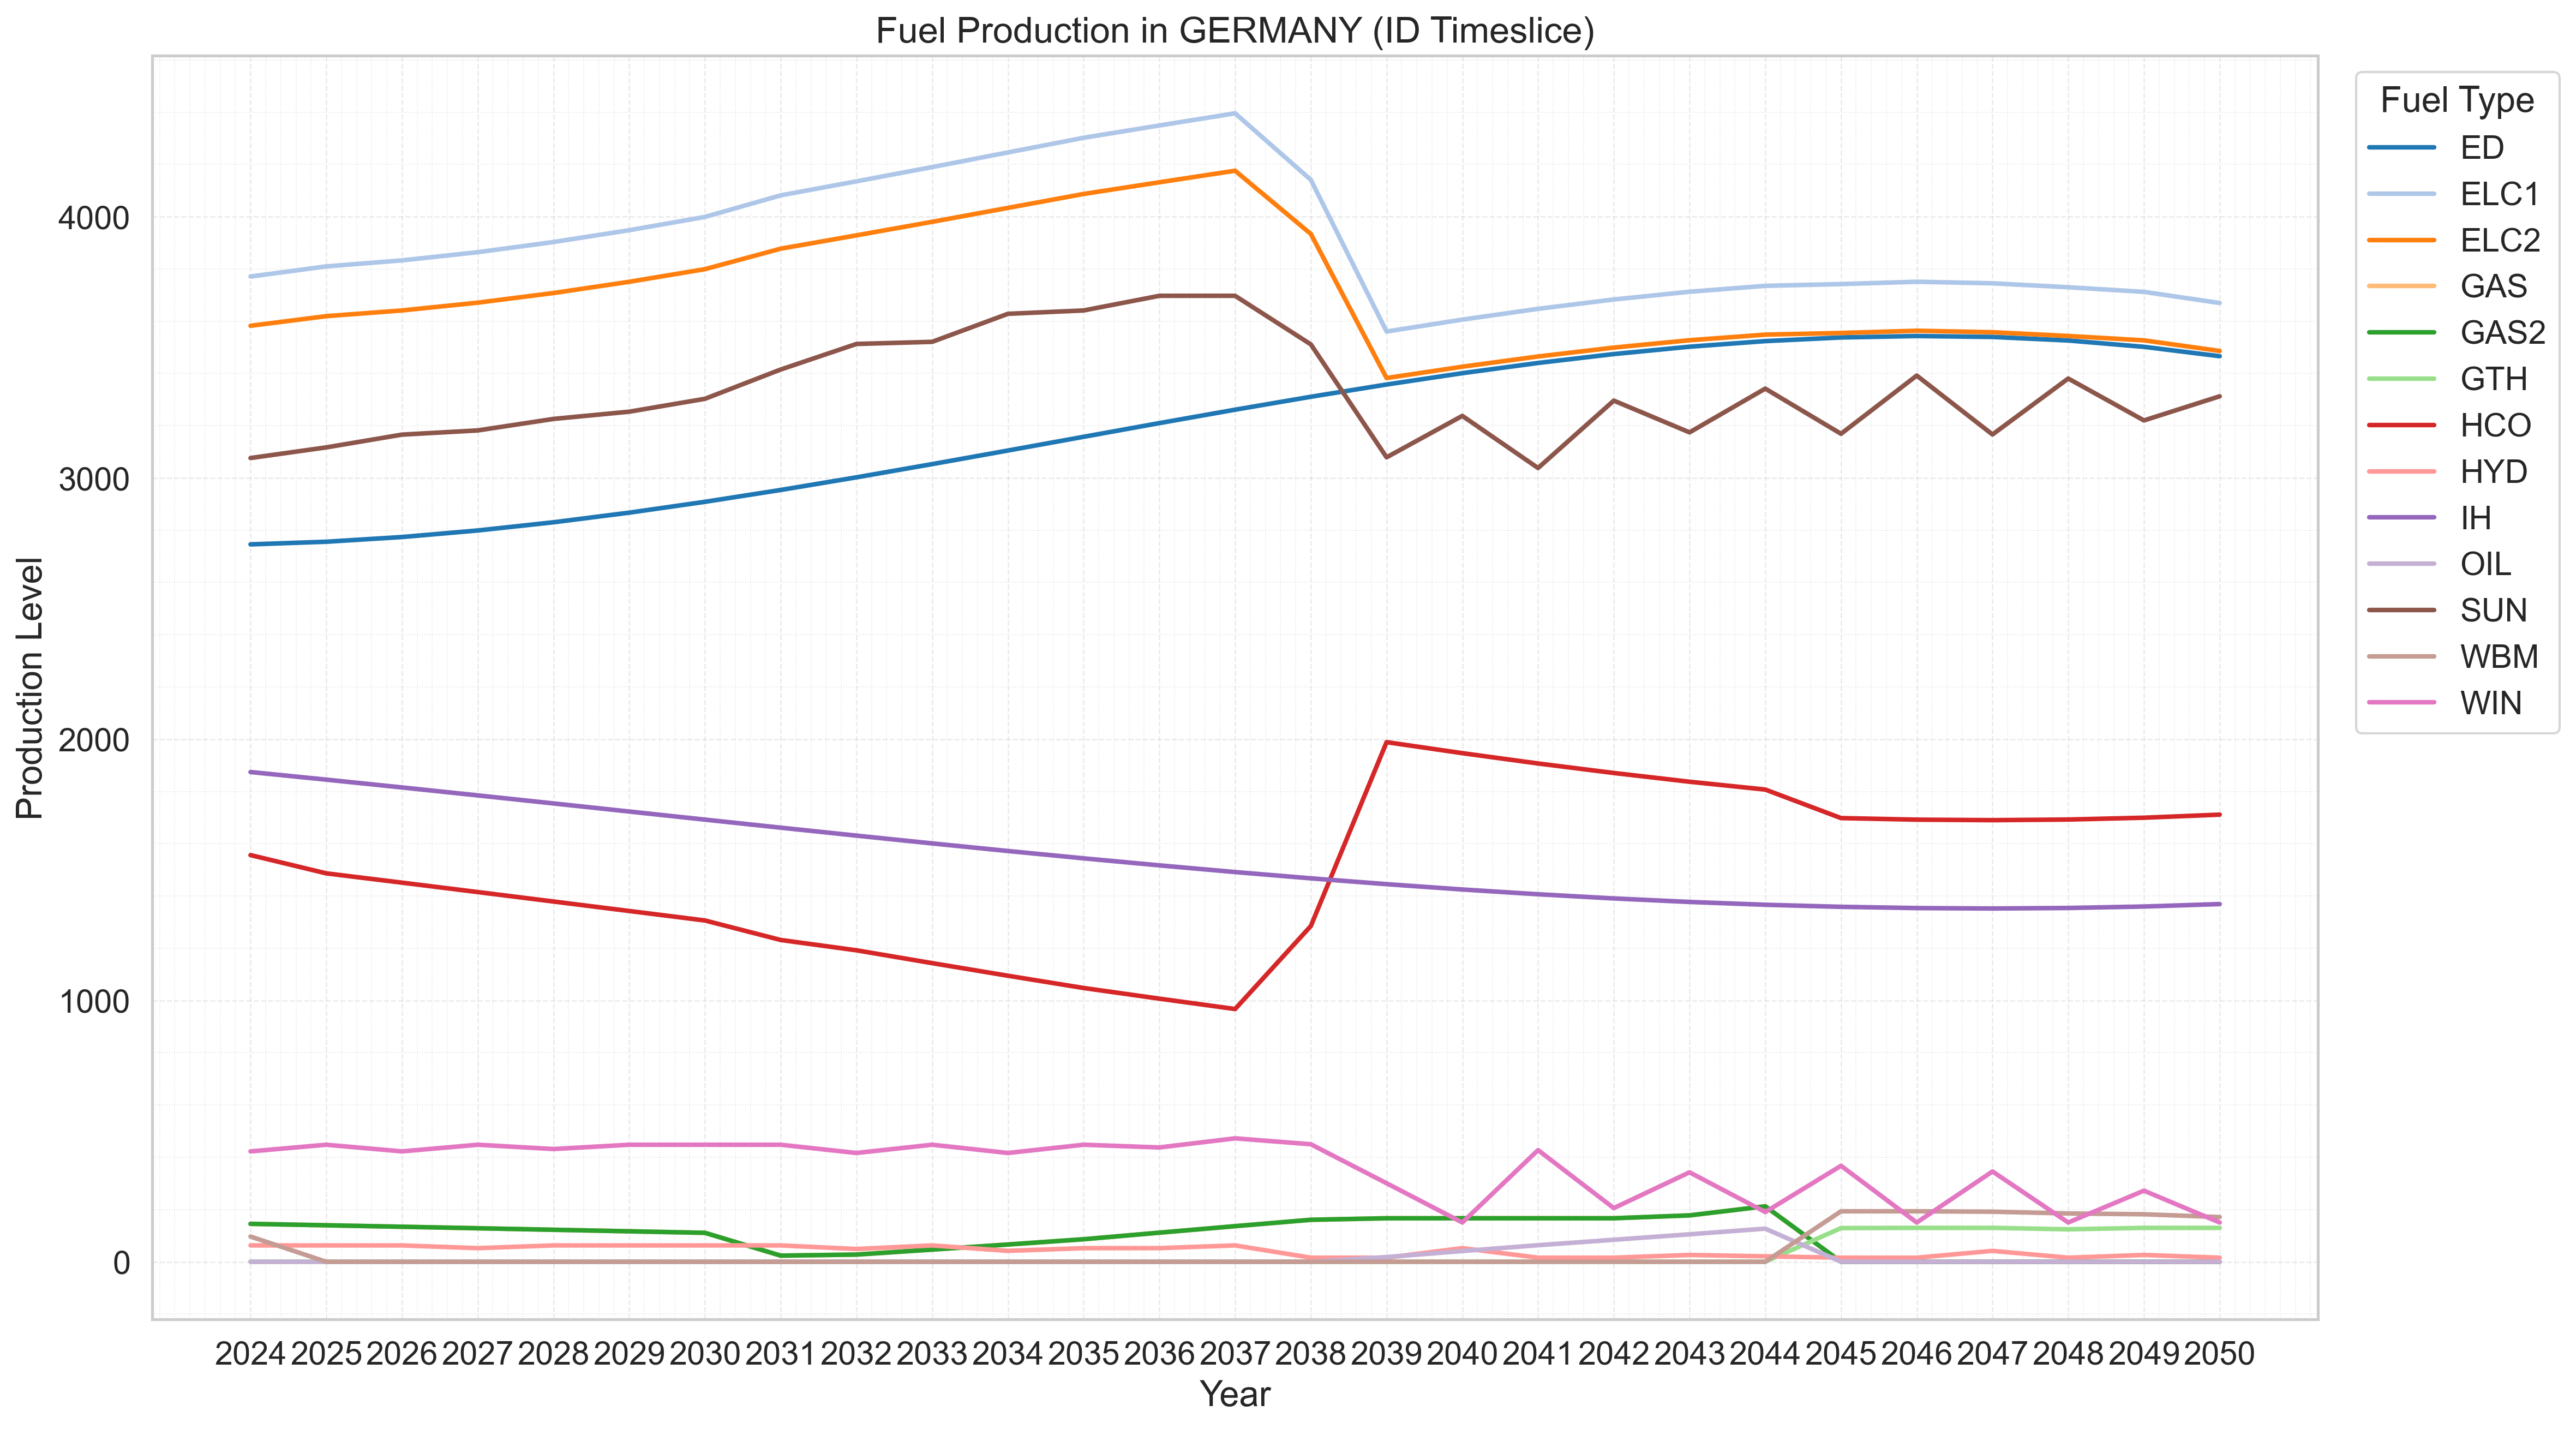

In [32]:
df1.columns = ['Region', 'Fuel', 'Year', 'Level', 'Marginal', 'Lower', 'Upper', 'Scale']

# Filter for a single region (Germany) and a chosen timeslice, e.g., 'ID'
region = 'GERMANY'
#timeslice = 'ID'
df_filtered = df1[(df1['Region'] == region)]

# Pivot so fuels are columns
df_pivot = df_filtered.pivot(index='Year', columns='Fuel', values='Level')


sns.set_theme(style="whitegrid", font_scale=1.3)


palette = sns.color_palette("tab20", n_colors=len(df_pivot.columns))
fuel_order = []

plt.figure(figsize=(16, 9), dpi=300)
for idx, fuel in enumerate(df_pivot.columns):
    #if fuel == 'GAS':
       fuel_order.append(fuel)
       sns.lineplot(x=df_pivot.index, y=df_pivot[fuel], label=fuel, color=palette[idx], linewidth=2)

plt.xlabel('Year')
plt.ylabel('Production Level')
plt.title(f'Fuel Production in {region} ({timeslice} Timeslice)', fontsize=16)

plt.grid(visible=True, which='major', linestyle='--', linewidth=0.6)
plt.minorticks_on()
plt.grid(visible=True, which='minor', linestyle=':', linewidth=0.4, alpha=0.5)

plt.legend(title='Fuel Type', bbox_to_anchor=(1.01, 1), loc='upper left', frameon=True)
plt.tight_layout()

plt.savefig('fuel_production_lineplot.png')

plt.show()

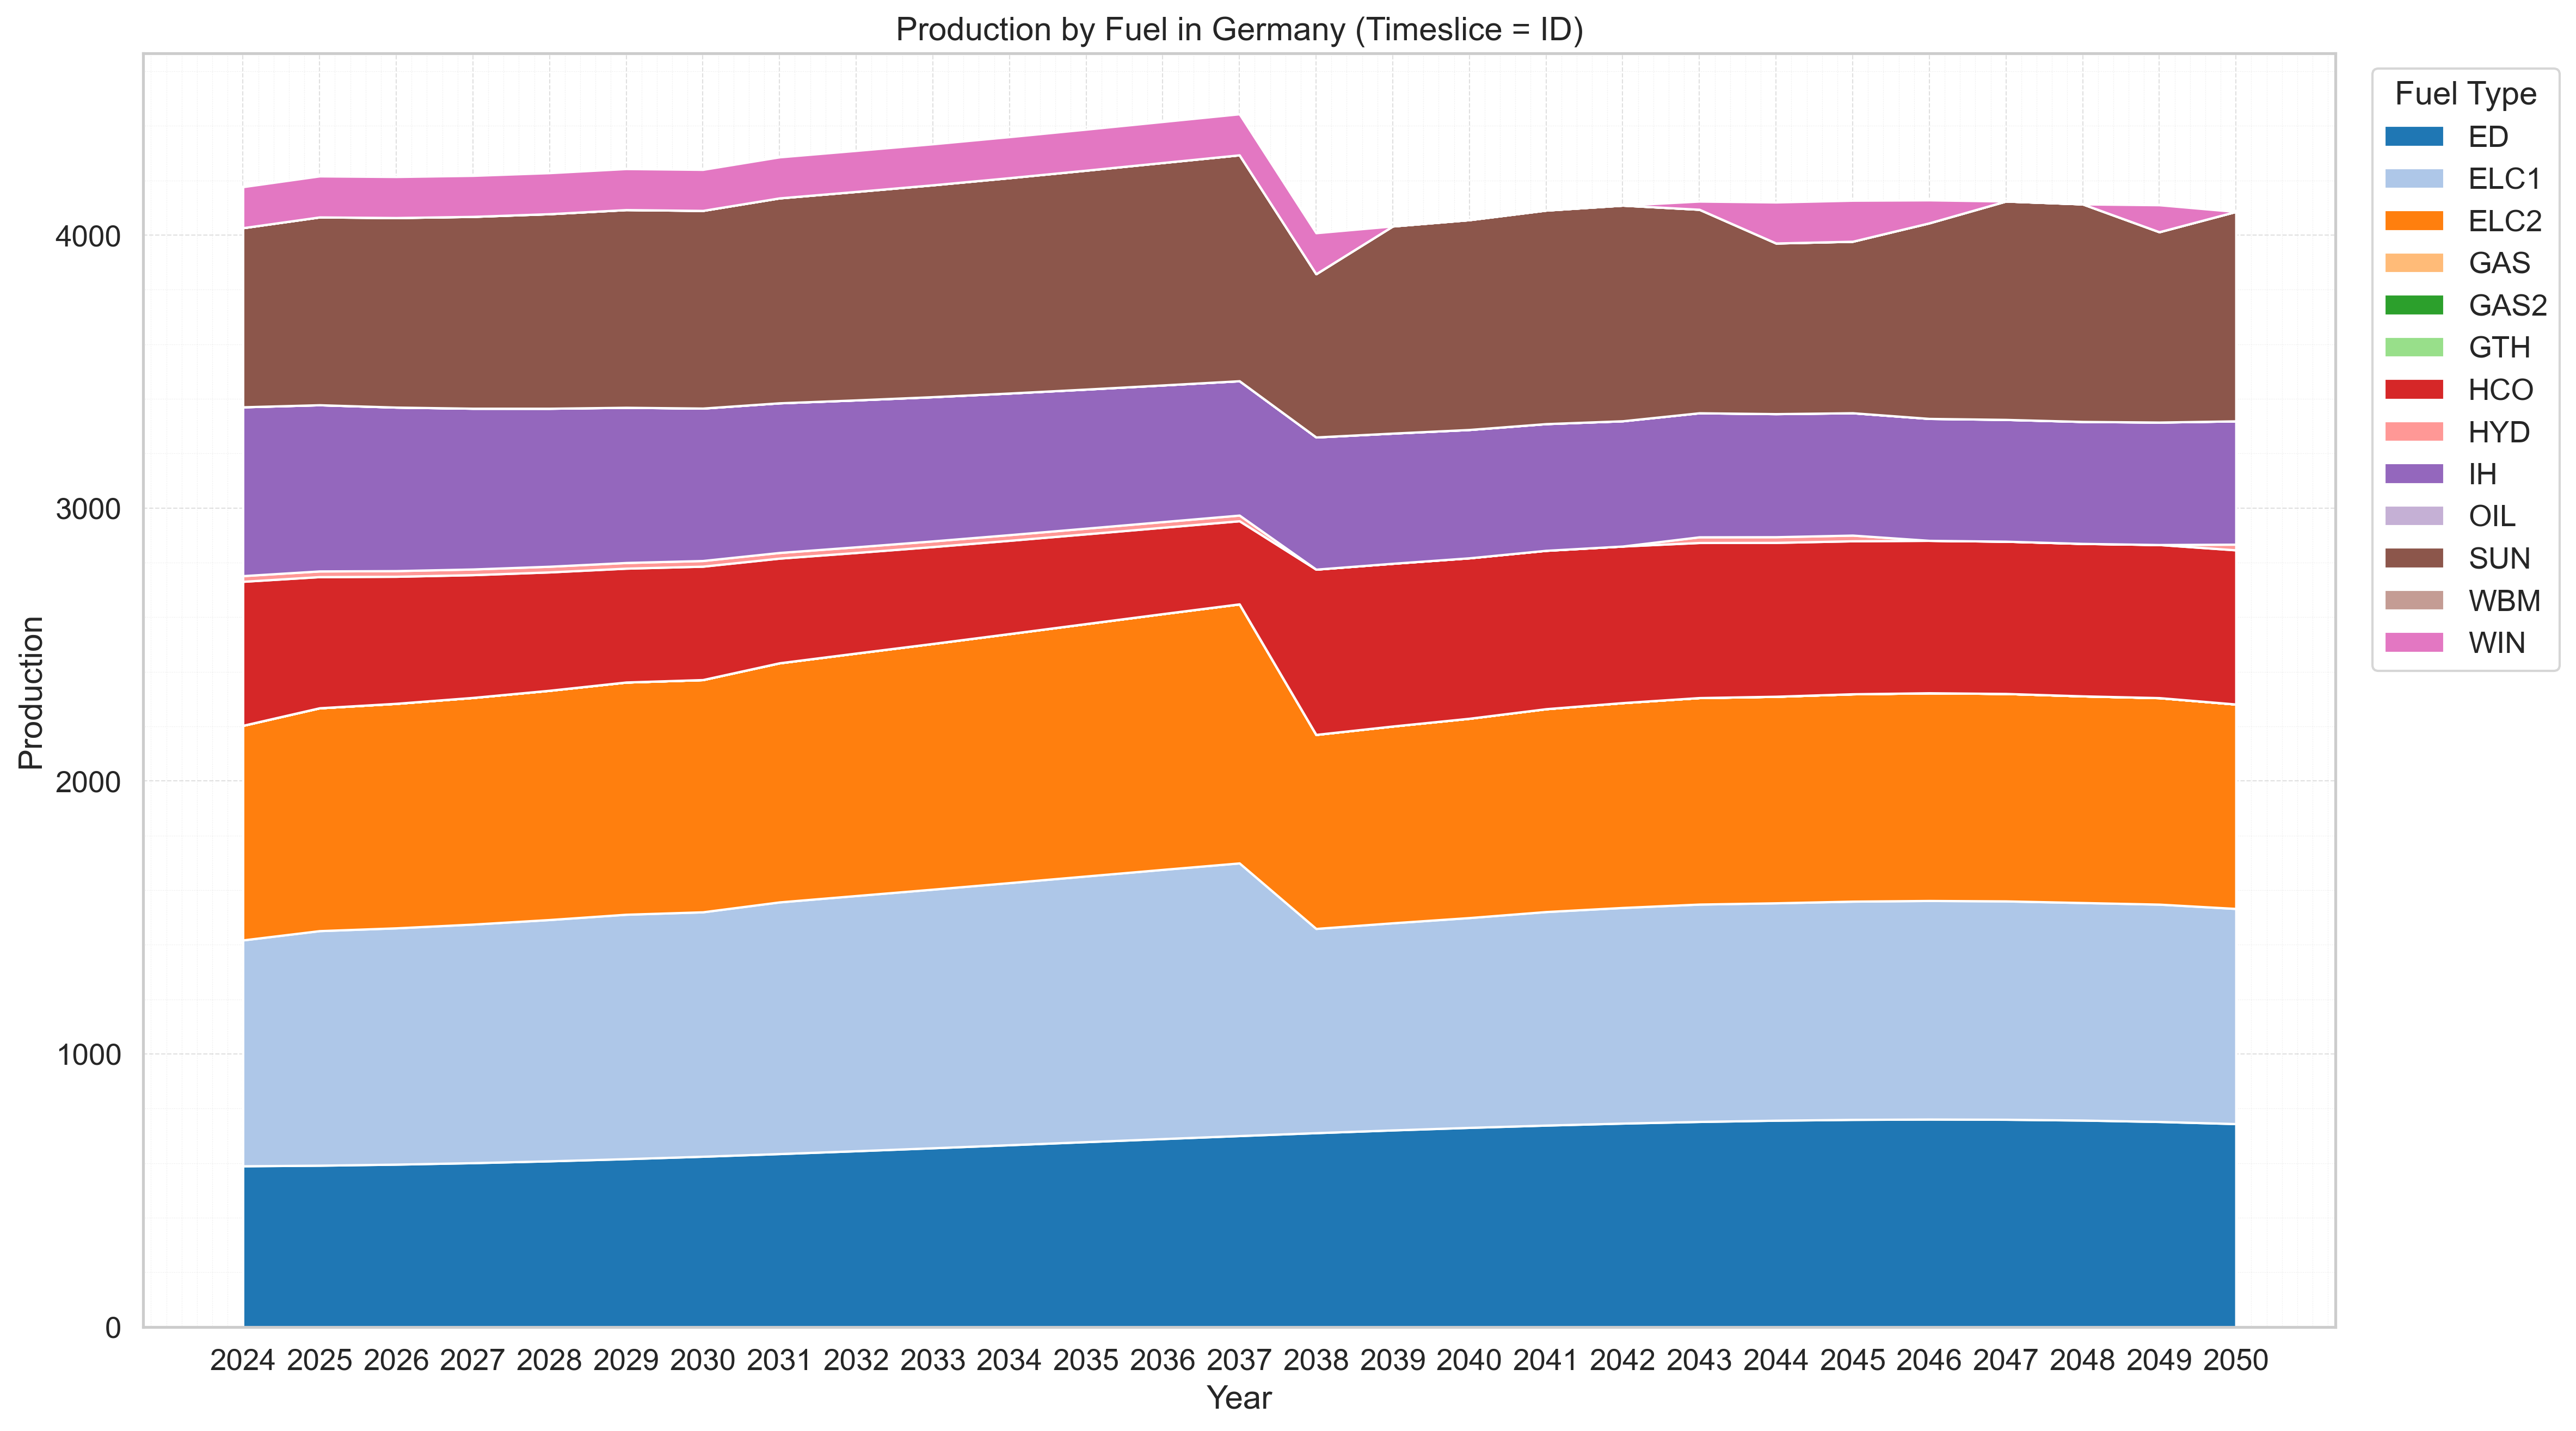

In [12]:
# Seaborn style and font scaling
sns.set_theme(style="whitegrid", font_scale=1.2)
plt.rcParams.update({
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'grid.linewidth': 0.5,
    'axes.grid': True,
    'grid.alpha': 0.4
})


region = 'GERMANY'
timeslice = 'ID'
df_filtered = df1[(df1['Region'] == region) & (df1['Timeslice'] == timeslice)]
df_pivot = df_filtered.pivot(index='Year', columns='Fuel', values='Level').fillna(0)

fuels = [f for f in fuel_order if f in df_pivot.columns]
df_pivot = df_pivot[fuels]

palette = sns.color_palette("tab20", len(fuels))

fig, ax = plt.subplots(figsize=(16, 9), dpi=300)
ax.stackplot(df_pivot.index, df_pivot.T.values, labels=fuels, colors=palette)

ax.set_xlabel('Year')
ax.set_ylabel('Production')
ax.set_title(f'Production by Fuel in Germany (Timeslice = {timeslice})')

ax.minorticks_on()
ax.grid(which='major', linestyle='--', linewidth=0.5, alpha=0.6)
ax.grid(which='minor', linestyle=':', linewidth=0.3, alpha=0.4)

ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1), title="Fuel Type", frameon=True)
plt.tight_layout()

#plt.savefig('fuel_production_areaplot.png')

plt.show()



In [13]:
df2 = df['TotalDiscountedCost']
df2.columns = ['Region', 'Year', 'Level', 'Marginal', 'Lower', 'Upper', 'Scale']

df2.head()

,Region,Year,Level,Marginal,Lower,Upper,Scale
0,GERMANY,2024,254575.302534,0.0,0.0,inf,1.0
1,GERMANY,2025,37637.023831,0.0,0.0,inf,1.0
2,GERMANY,2026,25757.474286,0.0,0.0,inf,1.0
3,GERMANY,2027,24867.582211,0.0,0.0,inf,1.0
4,GERMANY,2028,23895.969266,0.0,0.0,inf,1.0


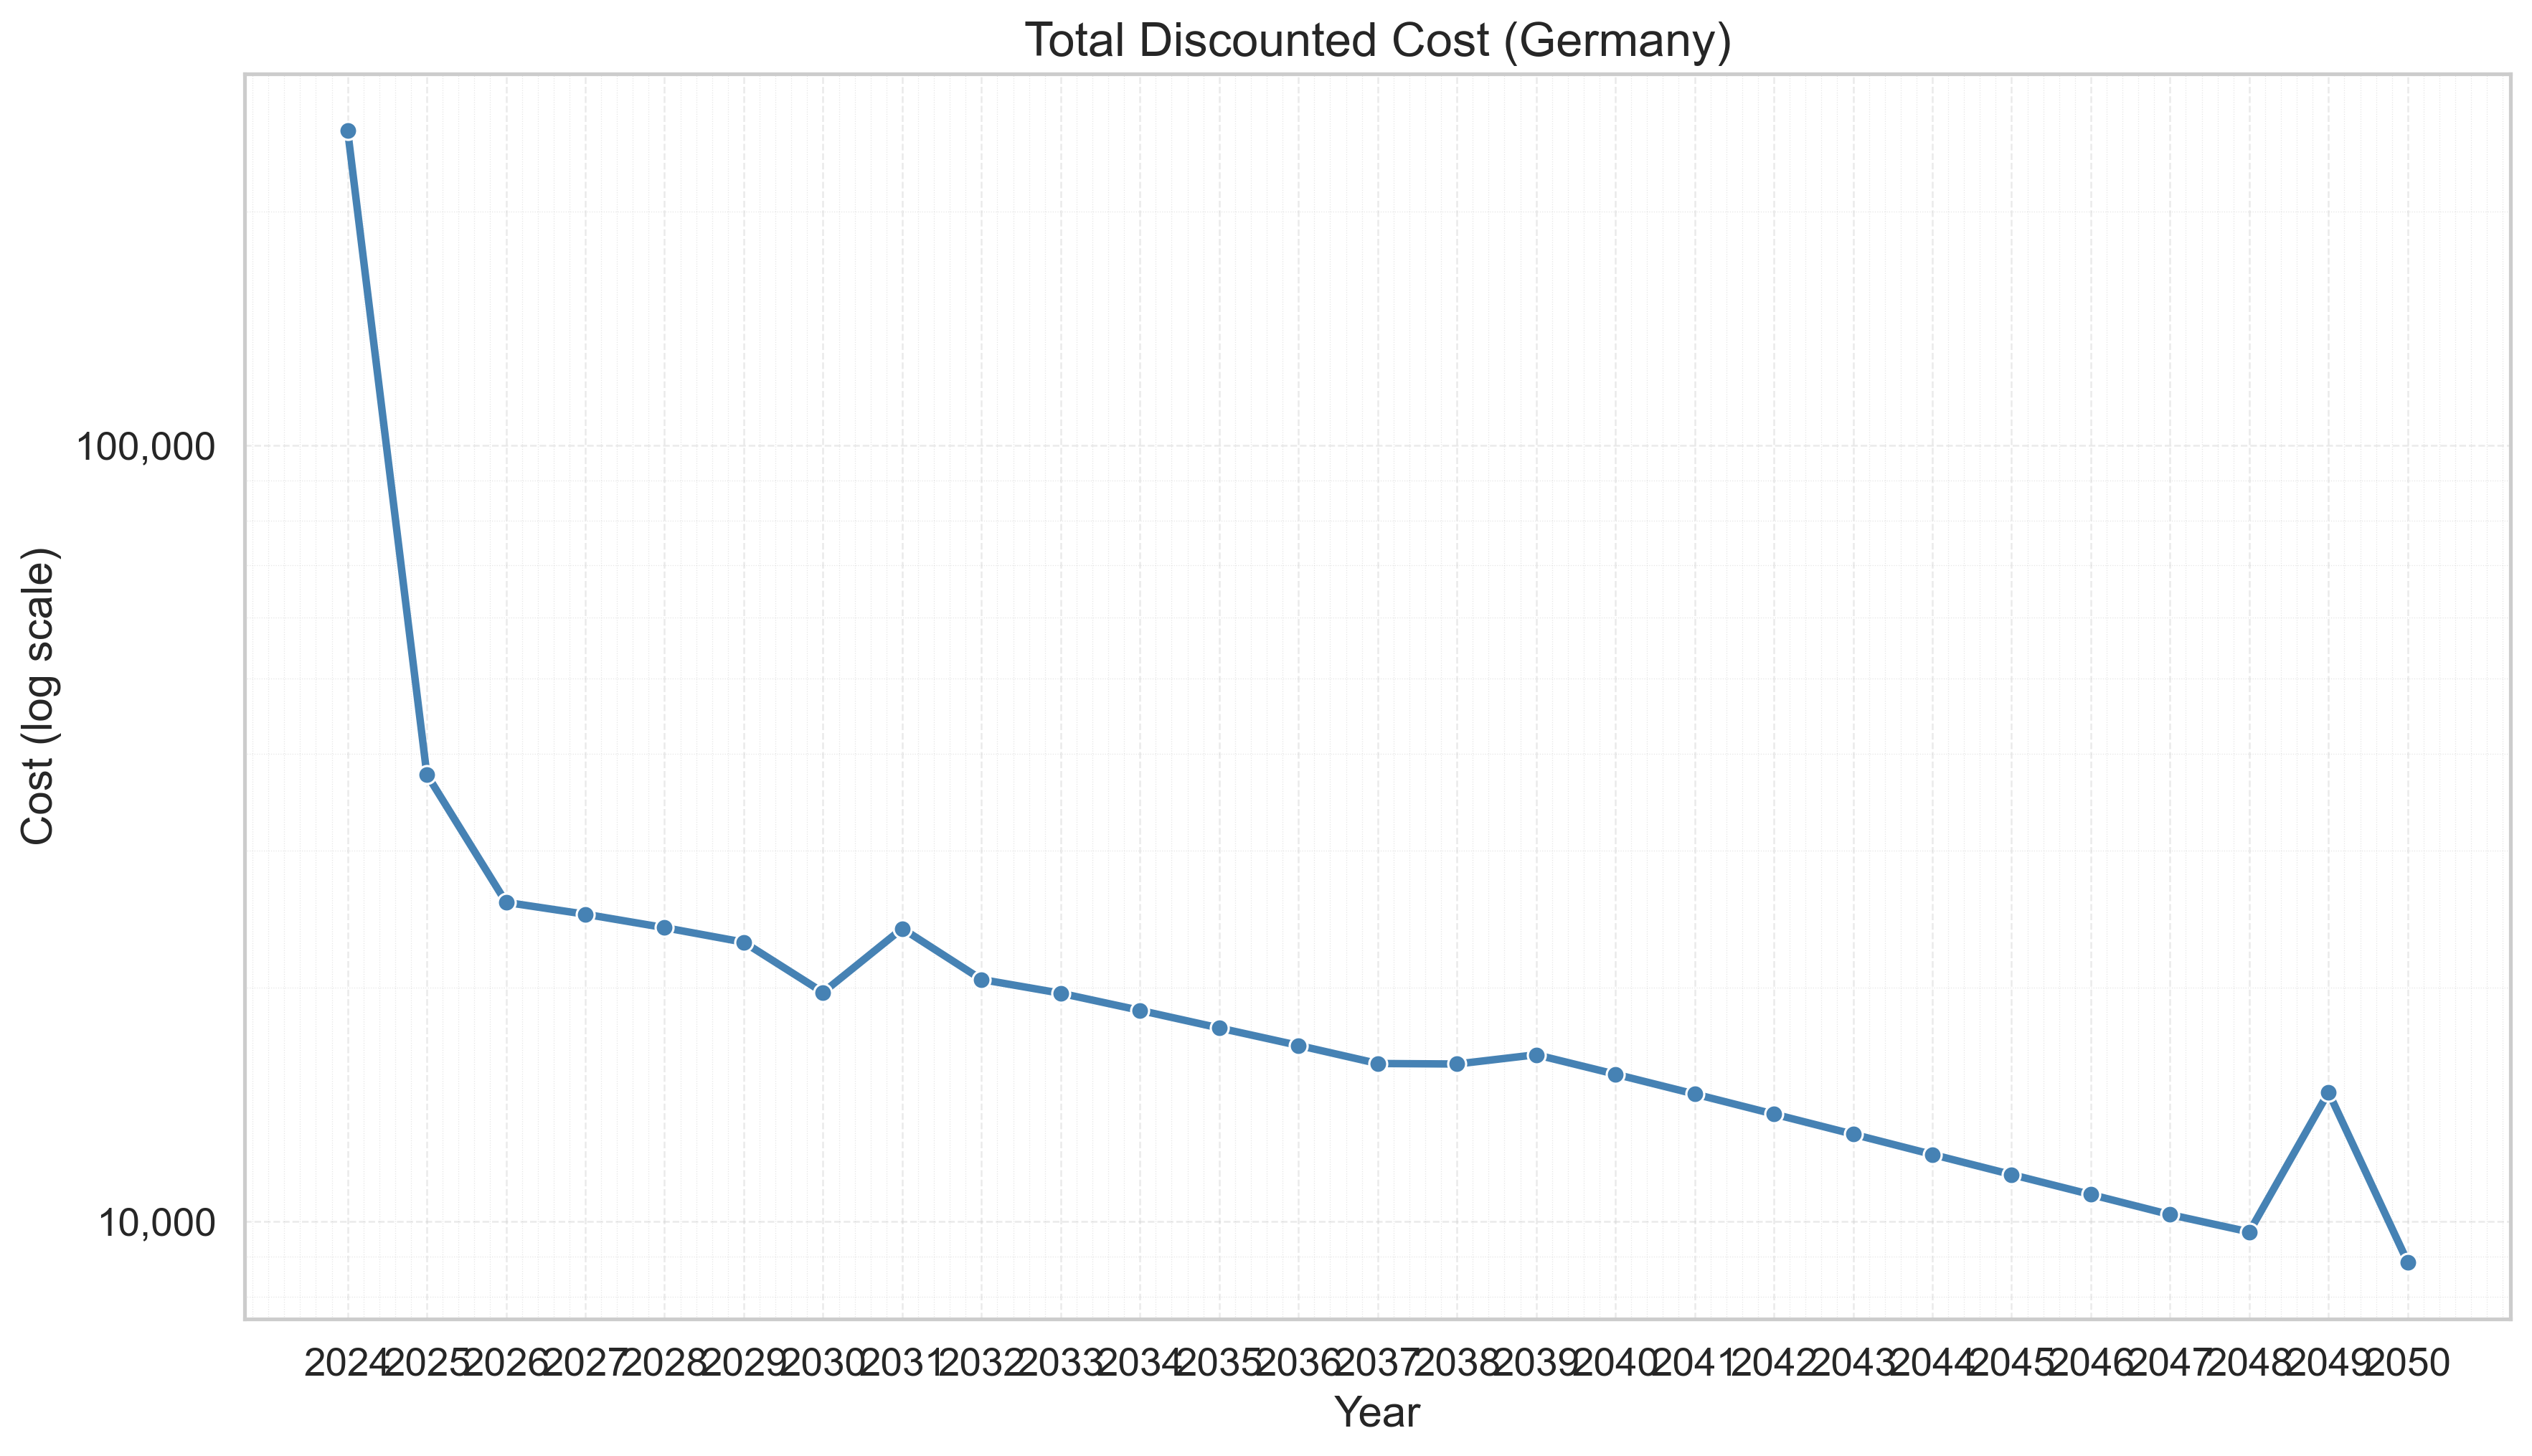

In [14]:
import matplotlib.ticker as ticker

plt.figure(figsize=(12, 7), dpi=300)

sns.lineplot(x=df2['Year'], y=df2['Level'], marker='o', linewidth=2.5, color='steelblue')

plt.xlabel('Year')
plt.ylabel('Cost (log scale)')
plt.title('Total Discounted Cost (Germany)', fontsize=16)

plt.yscale('log')

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.minorticks_on()
plt.grid(True, which='major', linestyle='--', linewidth=0.6)
plt.grid(True, which='minor', linestyle=':', linewidth=0.3, alpha=0.5)

plt.tight_layout()

plt.show()

In [15]:
var_cost = df['VariableCost']
#var_cost.loc[-1] = var_cost.columns 
#var_cost.index = var_cost.index + 1  # Shift index
#var_cost = var_cost.sort_index()     # Reorder rows

var_cost.columns = ['Region', 'Technology', 'Mode of Operation', 'Year', 'Value']

var_cost.head()

,Region,Technology,Mode of Operation,Year,Value
0,GERMANY,IMPGAS,1,2024,7.5
1,GERMANY,IMPGAS,1,2025,7.5
2,GERMANY,IMPGAS,1,2026,7.5
3,GERMANY,IMPGAS,1,2027,7.5
4,GERMANY,IMPGAS,1,2028,7.5


In [16]:
unique_techs = var_cost['Technology'].unique()
print(f"Number of unique technologies: {len(unique_techs)}")
print("Technologies:", unique_techs)

Number of unique technologies: 25
Technologies: ['IMPGAS' 'GRIDGAS' 'IMPHCO1' 'IMPOIL1' 'IMPBIO1' 'VIR_SUN' 'VIR_WIN'
 'VIR_GTH' 'VIR_HYD' 'COAL' 'GFPP' 'ROR' 'OIL_GEN' 'BIO' 'GEO' 'SPV'
 'WPP_ON' 'WPP_OFF' 'GRID_ELC' 'BEES' 'STOR_HYDRO' 'FEU' 'IHE' 'IHG' 'IHC']


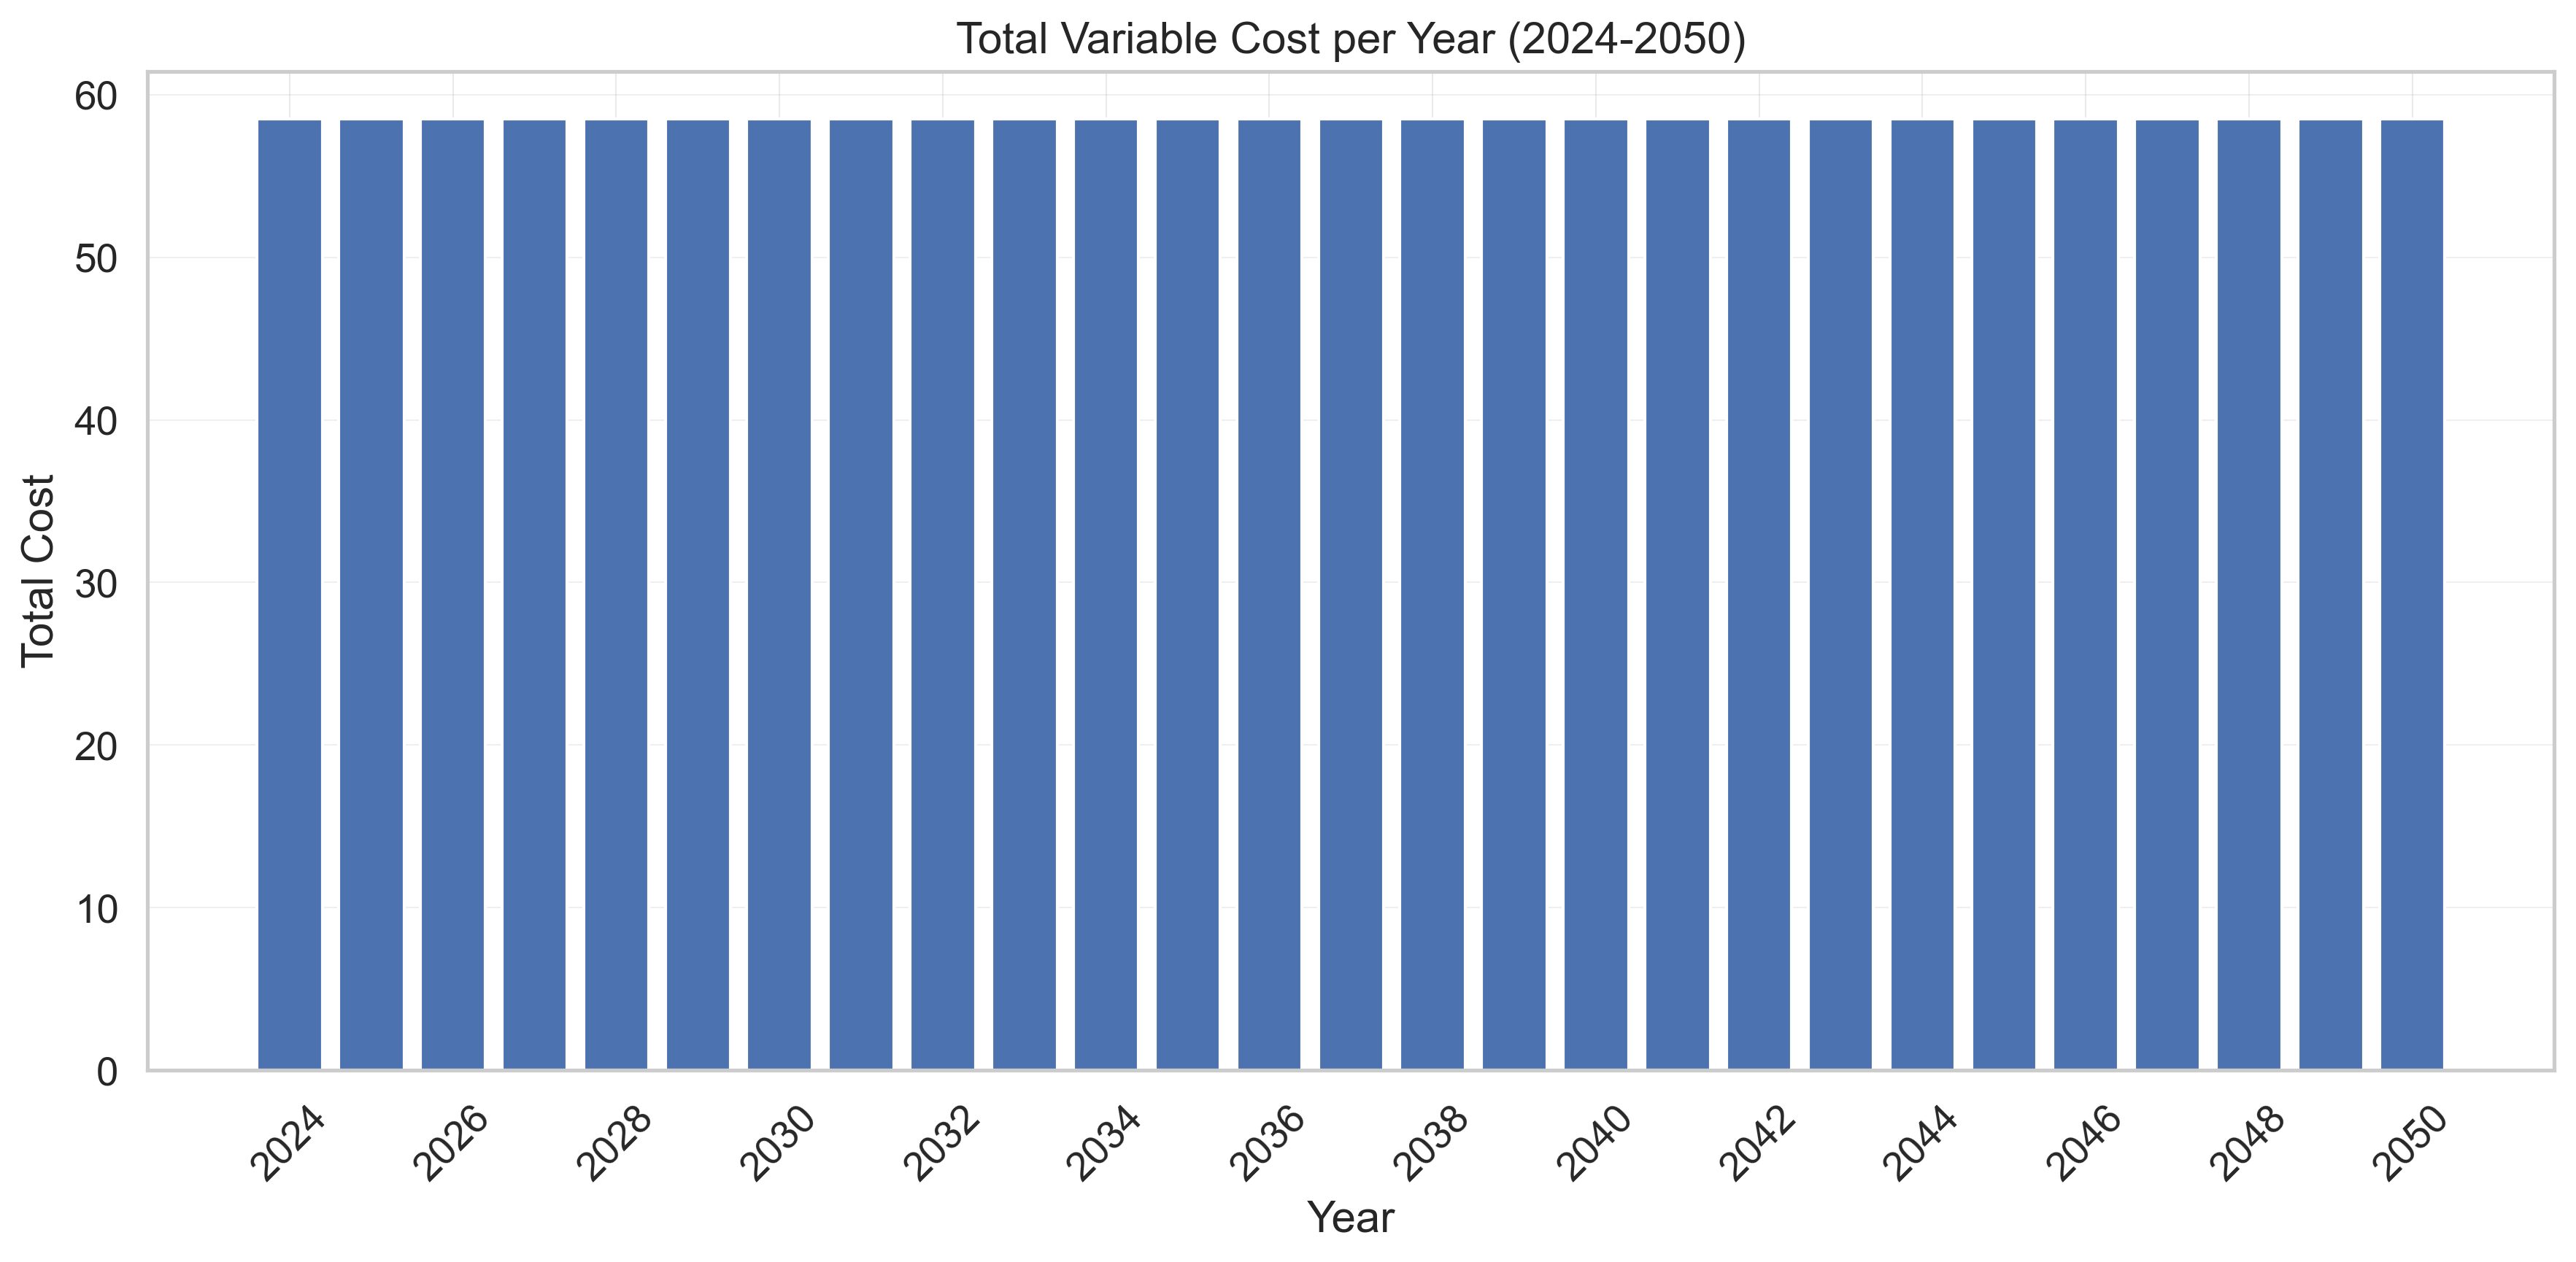

In [17]:
var_cost['Year'] = var_cost['Year'].astype(int)

yearly_costs = var_cost.groupby('Year')['Value'].sum()

yearly_costs = yearly_costs[(yearly_costs.index >= 2024) & (yearly_costs.index <= 2050)]

plt.figure(figsize=(12, 6))
plt.bar(yearly_costs.index, yearly_costs.values)
plt.xlabel('Year')
plt.ylabel('Total Cost')
plt.title('Total Variable Cost per Year (2024-2050)')
plt.xticks(range(2024, 2051, 2), rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Total discounted cost by technology

In [18]:
tot_cost_tech =  df['TotalDiscountedCostByTechnology']
tot_cost_tech.head()

,REGION,TECHNOLOGY,YEAR,Level,Marginal,Lower,Upper,Scale
0,GERMANY,IMPGAS,2024,4962.083124,0.0,0.0,inf,1.0
1,GERMANY,IMPGAS,2025,4233.402984,0.0,0.0,inf,1.0
2,GERMANY,IMPGAS,2026,3976.820894,0.0,0.0,inf,1.0
3,GERMANY,IMPGAS,2027,3734.072048,0.0,0.0,inf,1.0
4,GERMANY,IMPGAS,2028,3504.789430,0.0,0.0,inf,1.0


In [19]:
tot_cost_tech.columns = ['Region', 'Technology', 'Year', 'Value', 'marginal', 'lower', 'upper', 'scale']

tot_cost_tech.head()

,Region,Technology,Year,Value,marginal,lower,upper,scale
0,GERMANY,IMPGAS,2024,4962.083124,0.0,0.0,inf,1.0
1,GERMANY,IMPGAS,2025,4233.402984,0.0,0.0,inf,1.0
2,GERMANY,IMPGAS,2026,3976.820894,0.0,0.0,inf,1.0
3,GERMANY,IMPGAS,2027,3734.072048,0.0,0.0,inf,1.0
4,GERMANY,IMPGAS,2028,3504.789430,0.0,0.0,inf,1.0


In [20]:
unique_techs = tot_cost_tech['Technology'].unique()
print(f"Number of unique technologies: {len(unique_techs)}")
print("Technologies:", unique_techs)

Number of unique technologies: 25
Technologies: ['IMPGAS' 'GRIDGAS' 'IMPHCO1' 'IMPOIL1' 'IMPBIO1' 'VIR_SUN' 'VIR_WIN'
 'VIR_GTH' 'VIR_HYD' 'COAL' 'GFPP' 'ROR' 'OIL_GEN' 'BIO' 'GEO' 'SPV'
 'WPP_ON' 'WPP_OFF' 'GRID_ELC' 'BEES' 'STOR_HYDRO' 'FEU' 'IHE' 'IHG' 'IHC']


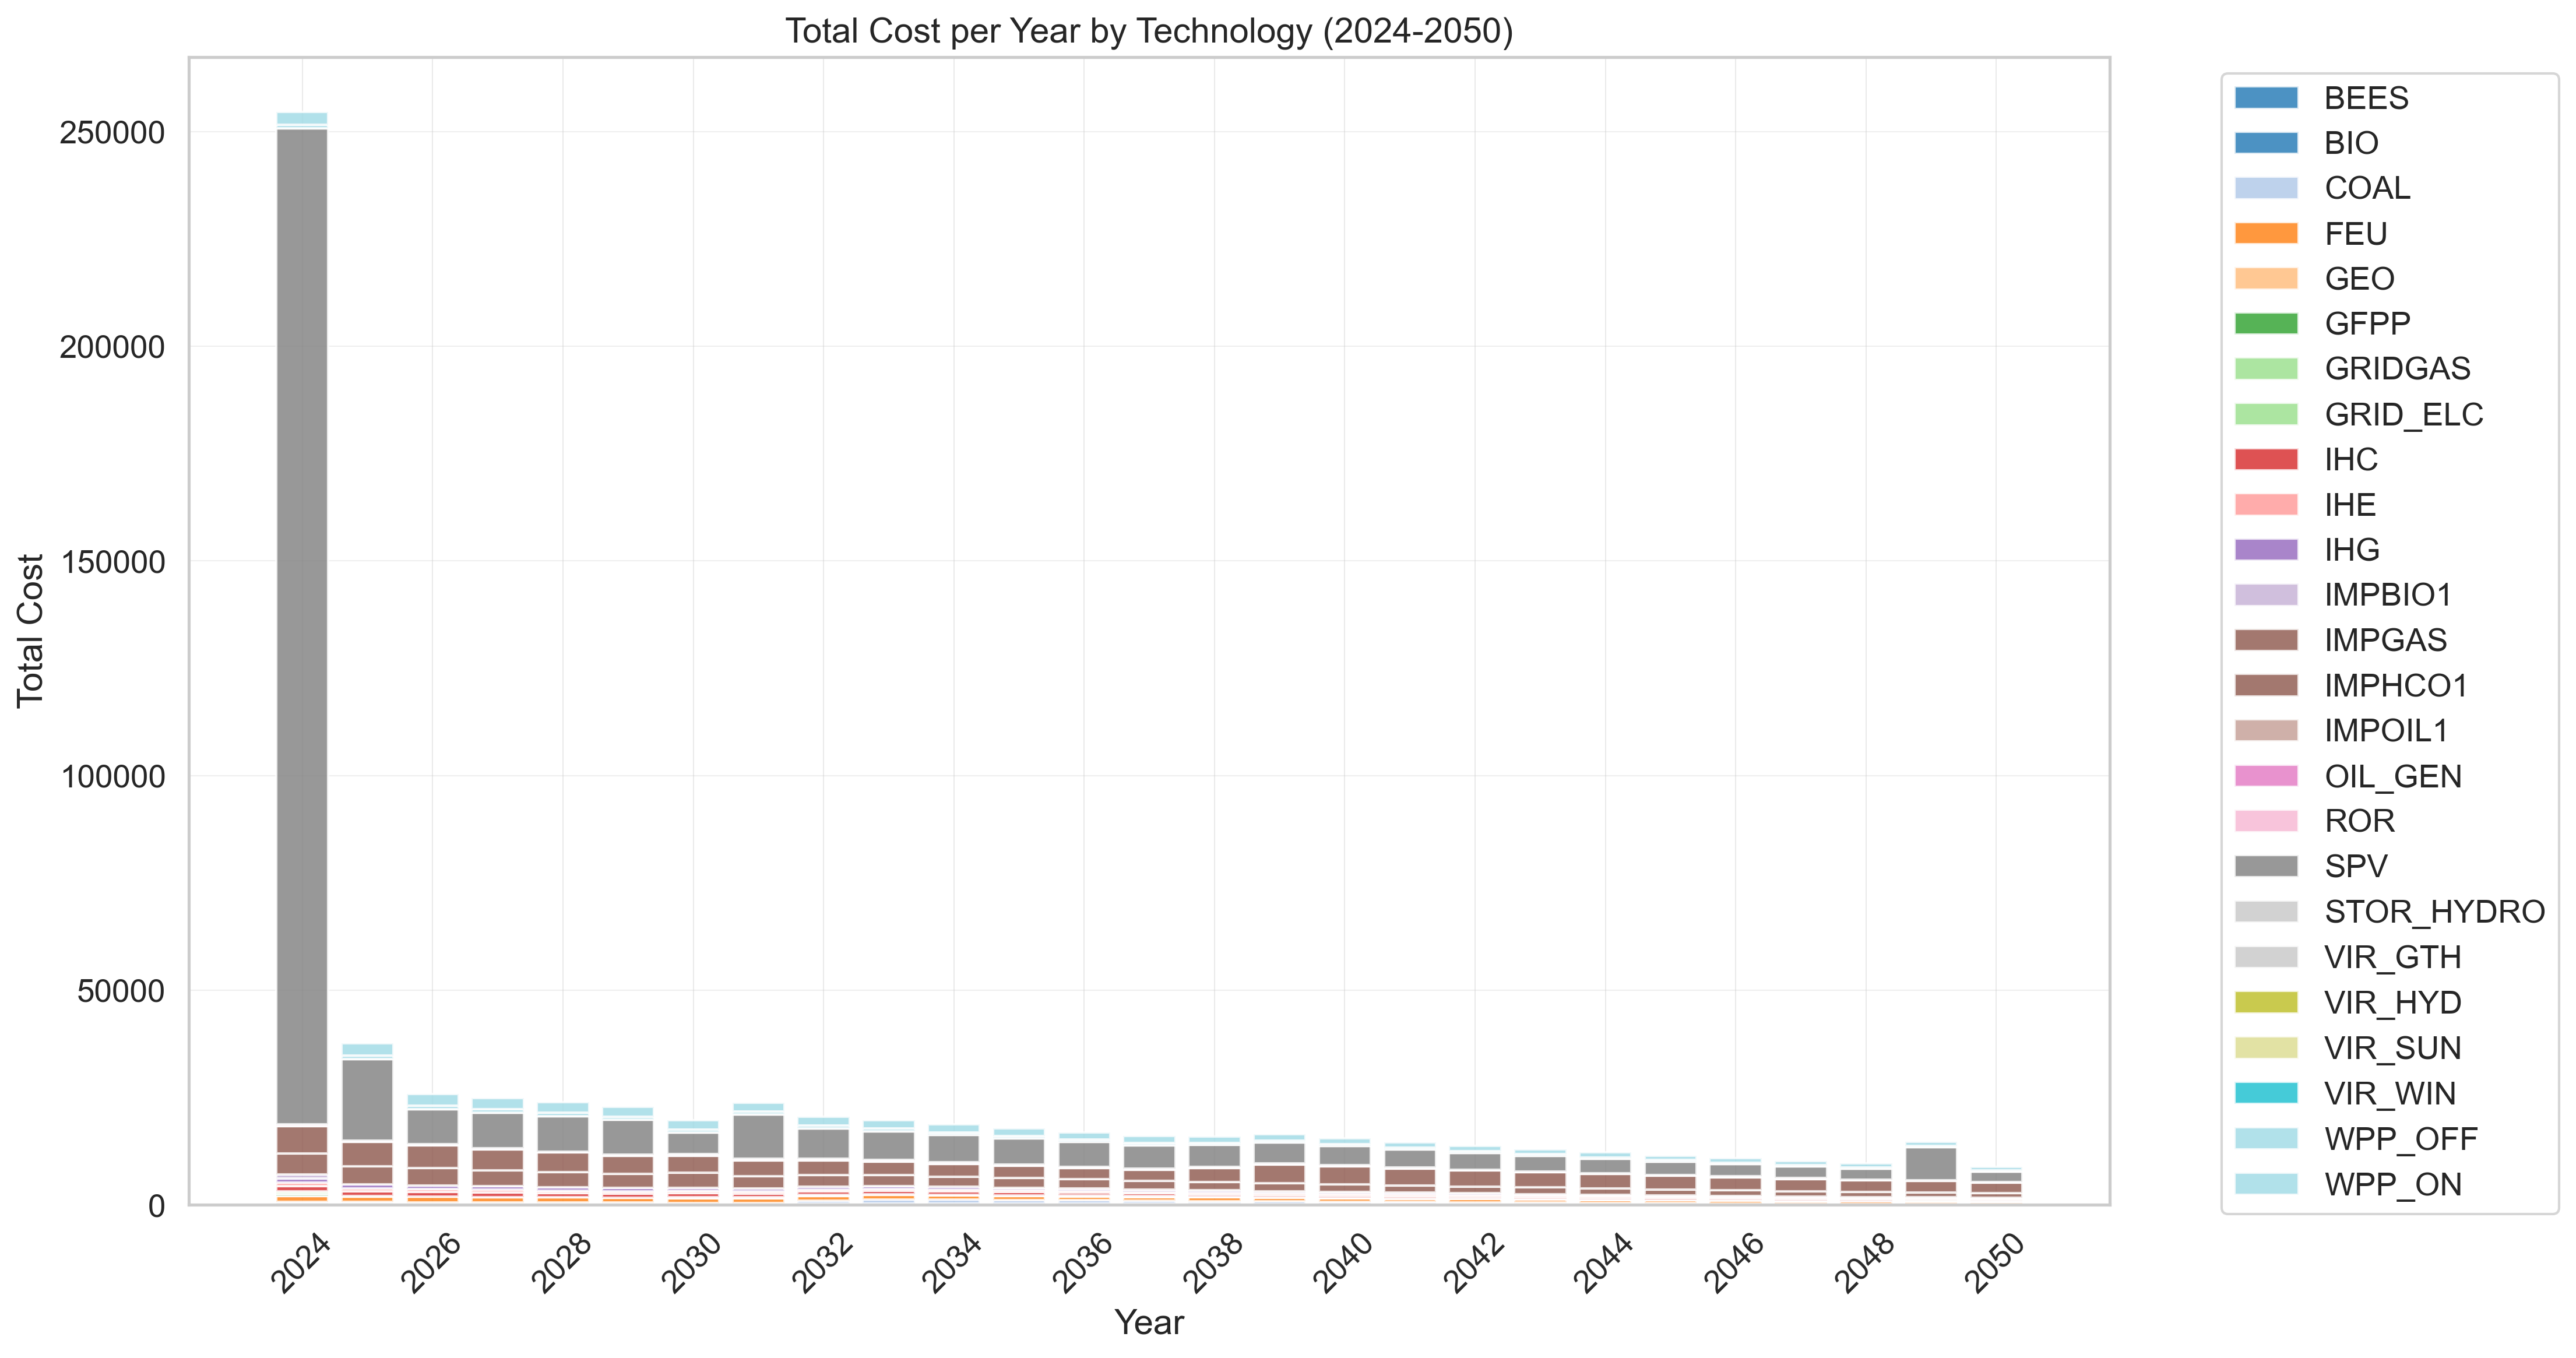

In [21]:
tot_cost_tech['Year'] = tot_cost_tech['Year'].astype(int)

filtered_data = tot_cost_tech[(tot_cost_tech['Year'] >= 2024) & (tot_cost_tech['Year'] <= 2050)]

pivot_data = filtered_data.pivot_table(index='Year', columns='Technology', values='Value', aggfunc='sum', fill_value=0)

plt.figure(figsize=(15, 8))
bottom = np.zeros(len(pivot_data))

technologies = pivot_data.columns
colors = plt.cm.tab20(np.linspace(0, 1, len(technologies)))

for i, tech in enumerate(technologies):
   plt.bar(pivot_data.index, pivot_data[tech], bottom=bottom, 
           label=tech, color=colors[i], alpha=0.8)
   bottom += pivot_data[tech]

plt.xlabel('Year')
plt.ylabel('Total Cost')
plt.title('Total Cost per Year by Technology (2024-2050)')
plt.xticks(range(2024, 2051, 2), rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

plt.savefig('total_cost_by_tech.png')

plt.show()

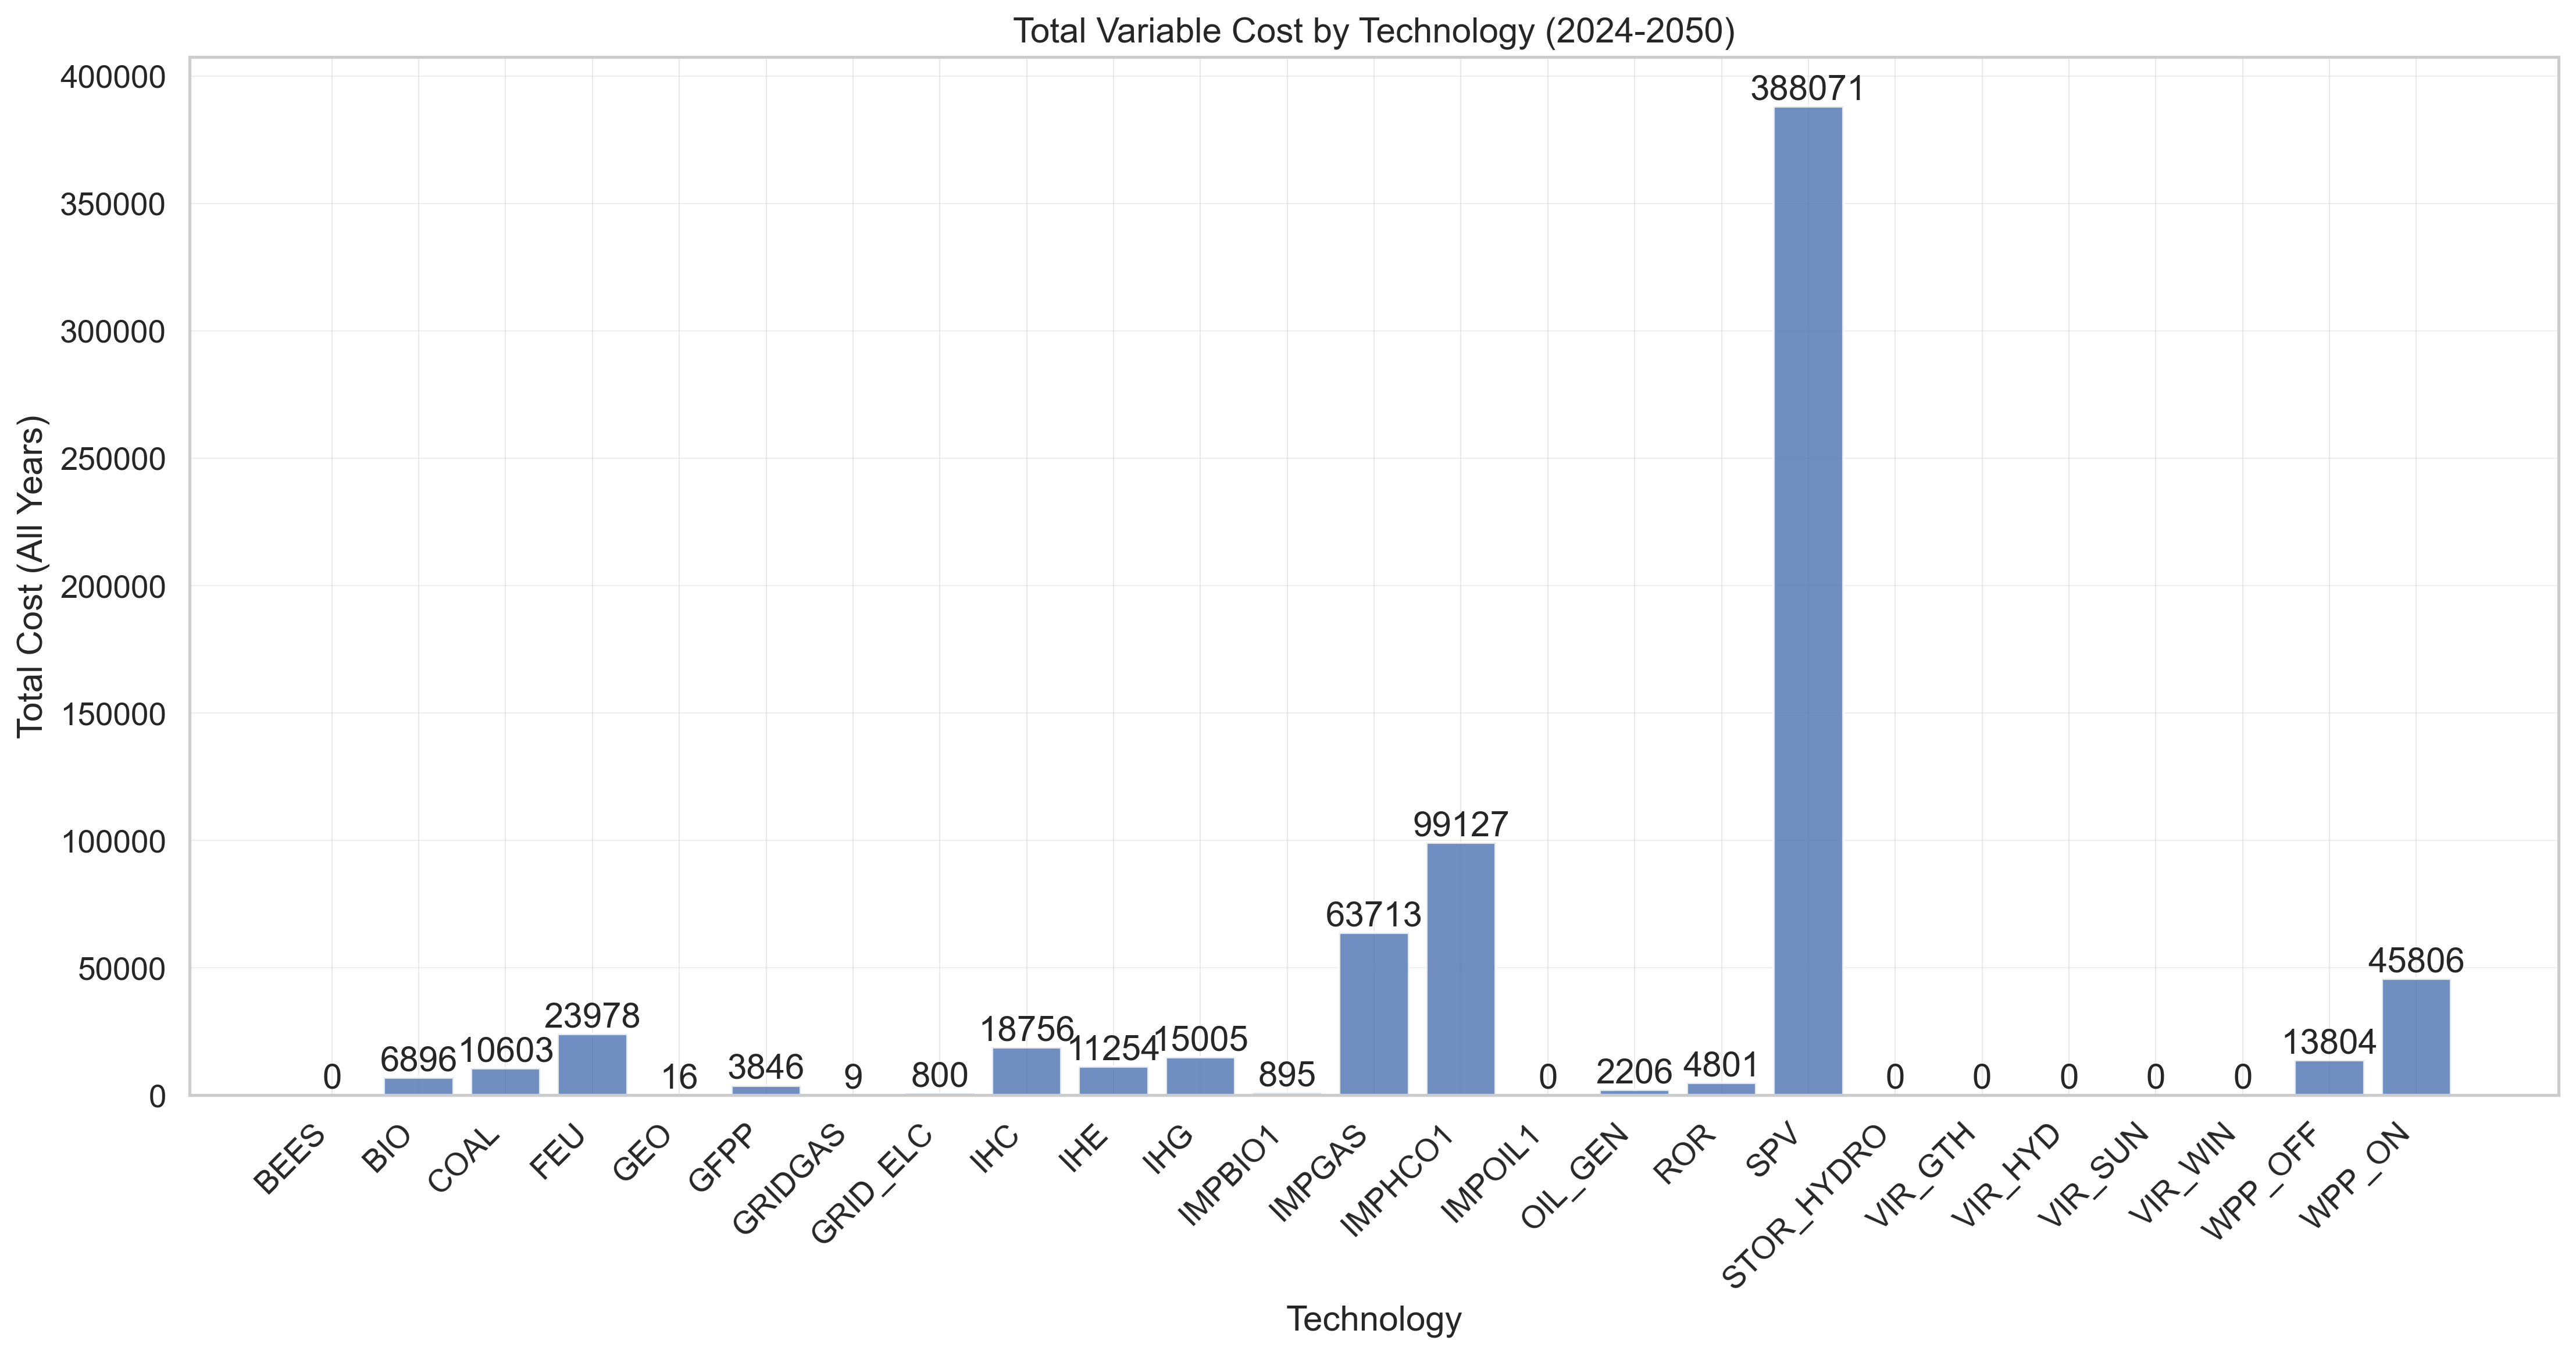

In [22]:
tot_cost_tech['Year'] = tot_cost_tech['Year'].astype(int)

tech_costs = tot_cost_tech.groupby('Technology')['Value'].sum()

plt.figure(figsize=(15, 8))
bars = plt.bar(range(len(tech_costs)), tech_costs.values, alpha=0.8)
plt.xlabel('Technology')
plt.ylabel('Total Cost (All Years)')
plt.title('Total Variable Cost by Technology (2024-2050)')
plt.xticks(range(len(tech_costs)), tech_costs.index, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

for i, bar in enumerate(bars):
   height = bar.get_height()
   plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.0f}',
            ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Total annual capacity

In [22]:
tot_cap_annual =  df['TotalCapacityAnnual']
tot_cap_annual.head()

,Region,Technology,Year,Value,marginal,lower,upper,scale
0,GERMANY,IMPGAS,2024,3333.805714,0,0,inf,1
1,GERMANY,IMPGAS,2025,3333.805714,0,0,inf,1
2,GERMANY,IMPGAS,2026,3333.805714,0,0,inf,1
3,GERMANY,IMPGAS,2027,3333.805714,0,0,inf,1
4,GERMANY,IMPGAS,2028,3333.805714,0,0,inf,1


In [6]:
tot_cap_annual.columns = ['Region', 'Technology', 'Year', 'Value', 'marginal', 'lower', 'upper', 'scale']

tot_cap_annual.head()

,Region,Technology,Year,Value,marginal,lower,upper,scale
0,GERMANY,IMPGAS,2024,3333.805714,0,0,inf,1
1,GERMANY,IMPGAS,2025,3333.805714,0,0,inf,1
2,GERMANY,IMPGAS,2026,3333.805714,0,0,inf,1
3,GERMANY,IMPGAS,2027,3333.805714,0,0,inf,1
4,GERMANY,IMPGAS,2028,3333.805714,0,0,inf,1


In [7]:
unique_techs = tot_cap_annual['Technology'].unique()
print(f"Number of unique technologies: {len(unique_techs)}")
print("Technologies:", unique_techs)

Number of unique technologies: 25
Technologies: ['IMPGAS' 'GRIDGAS' 'IMPHCO1' 'IMPOIL1' 'IMPBIO1' 'VIR_SUN' 'VIR_WIN'
 'VIR_GTH' 'VIR_HYD' 'COAL' 'GFPP' 'ROR' 'OIL_GEN' 'BIO' 'GEO' 'SPV'
 'WPP_ON' 'WPP_OFF' 'GRID_ELC' 'BEES' 'STOR_HYDRO' 'FEU' 'IHE' 'IHG' 'IHC']


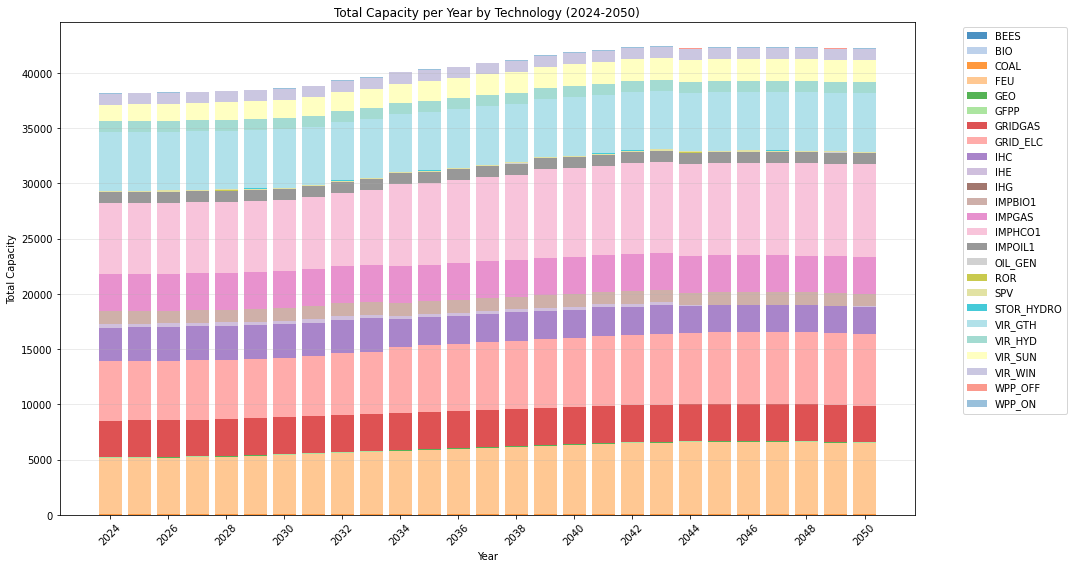

In [21]:
tot_cap_annual['Year'] = tot_cap_annual['Year'].astype(int)

filtered_data = tot_cap_annual[(tot_cap_annual['Year'] >= 2024) & (tot_cap_annual['Year'] <= 2050)]

pivot_data = filtered_data.pivot_table(index='Year', columns='Technology', values='Value', aggfunc='sum', fill_value=0)

plt.figure(figsize=(15, 8))
bottom = np.zeros(len(pivot_data))

technologies = pivot_data.columns
if len(technologies) > 20:
    colors = (sns.color_palette("tab20", 20) + 
              sns.color_palette("Set3", 12)[:-2] + 
              sns.color_palette("Pastel1", 9))[:len(technologies)]
else:
    colors = sns.color_palette("tab20", len(technologies))

for i, tech in enumerate(technologies):
   plt.bar(pivot_data.index, pivot_data[tech], bottom=bottom, 
           label=tech, color=colors[i], alpha=0.8)
   bottom += pivot_data[tech]
plt.xlabel('Year')
plt.ylabel('Total Capacity')
plt.title('Total Capacity per Year by Technology (2024-2050)')
plt.xticks(range(2024, 2051, 2), rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('total_capacity_by_tech.png')
plt.show()

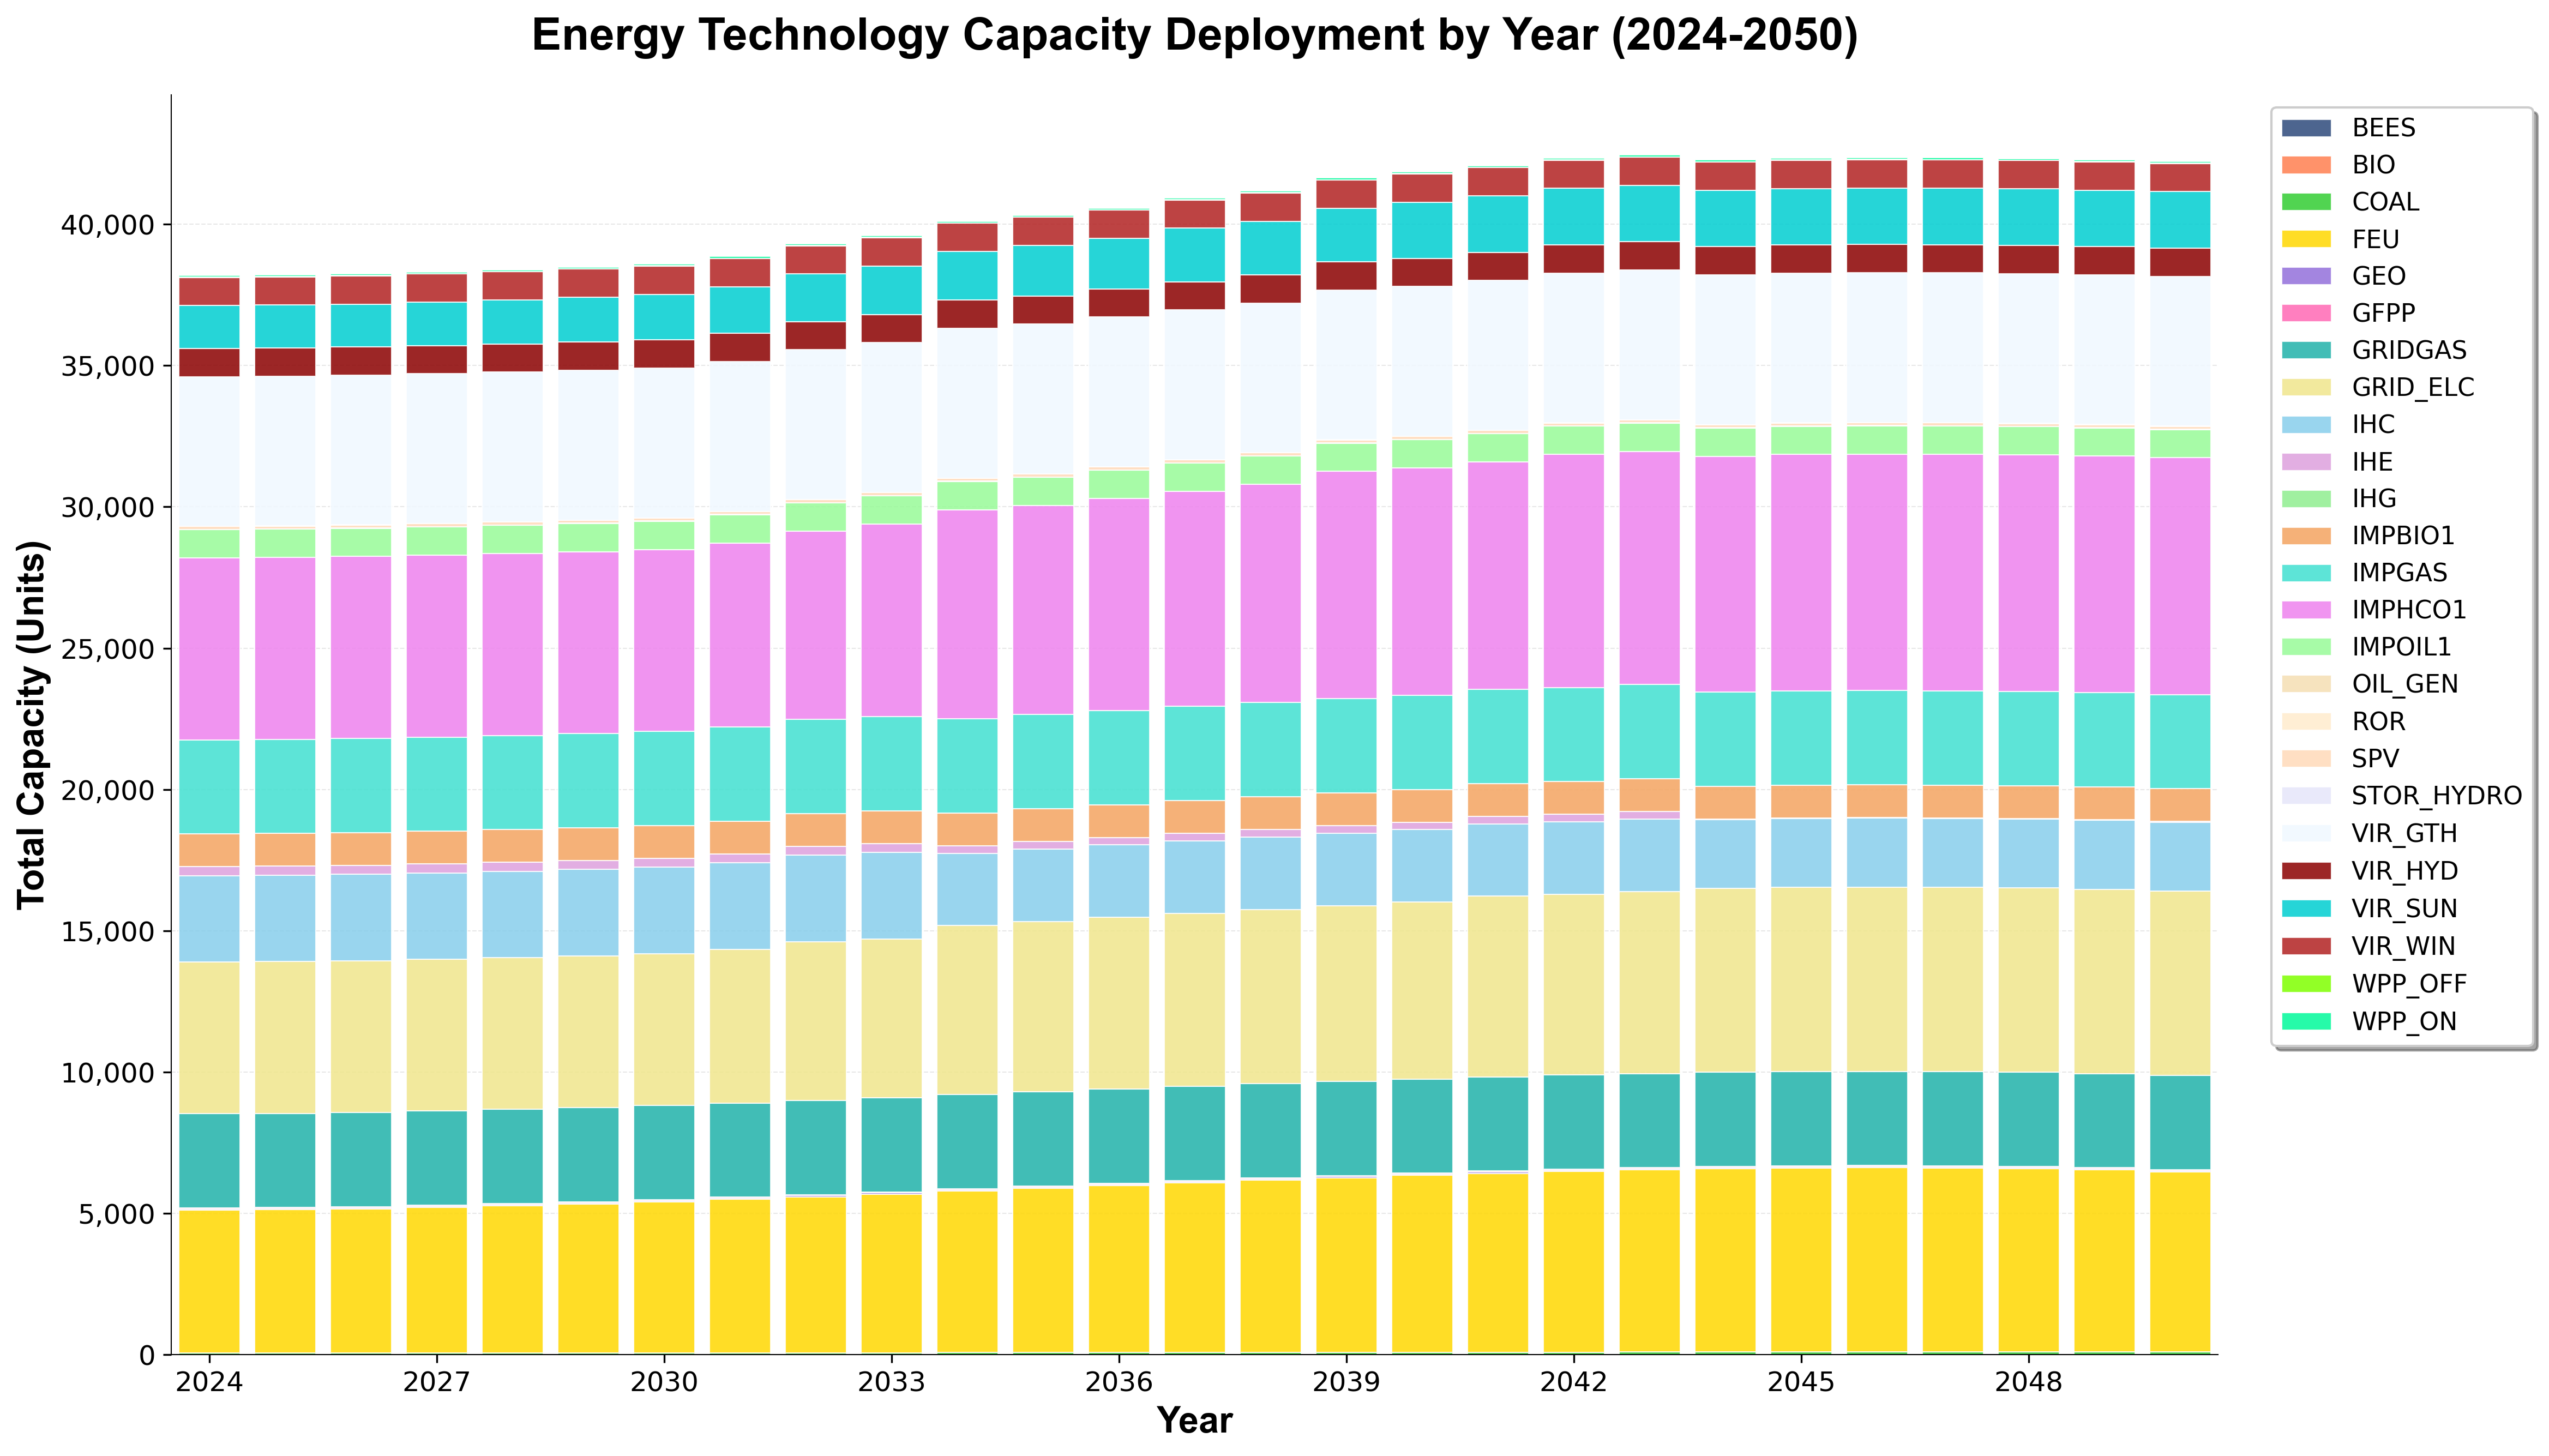

Text(2032, 7000, 'Key Milestone')

In [24]:
# Set the style to a professional theme
#plt.style.use('seaborn-v0_8-whitegrid') 

tot_cap_annual['Year'] = tot_cap_annual['Year'].astype(int)

filtered_data = tot_cap_annual[(tot_cap_annual['Year'] >= 2024) & (tot_cap_annual['Year'] <= 2050)]

pivot_data = filtered_data.pivot_table(index='Year', columns='Technology', values='Value', aggfunc='sum', fill_value=0)

fig, ax = plt.subplots(figsize=(16, 9), dpi=300)  # 16:9 aspect ratio standard for presentations


colors = ['#2E4A7C', '#FF7F50', '#32CD32', '#FFD700', '#9370DB', '#FF69B4', 
          '#20B2AA', '#F0E68C', '#87CEEB', '#DDA0DD', '#90EE90', '#F4A460',
          '#40E0D0', '#EE82EE', '#98FB98', '#F5DEB3', '#FFEBCD', '#FFDAB9',
          '#E6E6FA', '#F0F8FF', '#8B0000', '#00CED1', '#B22222', '#7FFF00', '#00FA9A']

while len(colors) < len(pivot_data.columns):
    colors.extend(colors)

bottom = np.zeros(len(pivot_data))
technologies = pivot_data.columns

bars = []
for i, tech in enumerate(technologies):
    bar = ax.bar(pivot_data.index, pivot_data[tech], bottom=bottom, 
                 label=tech, color=colors[i], alpha=0.85, edgecolor='white', 
                 linewidth=0.5)
    bars.append(bar)
    bottom += pivot_data[tech]

ax.set_xlabel('Year', fontsize=16, fontweight='bold', fontfamily='Arial')
ax.set_ylabel('Total Capacity (Units)', fontsize=16, fontweight='bold', fontfamily='Arial')
ax.set_title('Energy Technology Capacity Deployment by Year (2024-2050)', 
             fontsize=20, fontweight='bold', fontfamily='Arial', pad=20)

ax.set_xticks(range(2024, 2051, 3))  # Every 3 years for cleaner look
ax.set_xticklabels(range(2024, 2051, 3), fontsize=12, rotation=0)
ax.set_xlim(2023.5, 2050.5)

ax.tick_params(axis='y', labelsize=12)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)  # Ensure grid is behind bars

ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=11, 
          frameon=True, fancybox=True, shadow=True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

plt.tight_layout(rect=[0, 0, 0.98, 1])

# Save with high quality
plt.savefig('total_capacity_by_tech_presentation.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.savefig('total_capacity_by_tech_presentation.svg', bbox_inches='tight', 
            facecolor='white', edgecolor='none')  # SVG for vector graphics

plt.show()

total_yearly = pivot_data.sum(axis=1)
ax2 = ax.twinx()
ax2.plot(pivot_data.index, total_yearly, color='red', linewidth=3, 
         marker='o', markersize=6, label='Total Capacity')
ax2.set_ylabel('Total Capacity', color='red', fontsize=14, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')

ax.annotate('Key Milestone', xy=(2030, 5000), xytext=(2032, 7000),
            arrowprops=dict(arrowstyle='->', color='red', lw=2),
            fontsize=12, fontweight='bold')

### Total technology annual activity

In [12]:
tot_act_annual =  df['TotalTechnologyAnnualActivity']
tot_act_annual.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,level,marginal,lower,upper,scale
0,GERMANY,IMPGAS,2024,555.745413,0,0,inf,1
1,GERMANY,IMPGAS,2025,539.663127,0,0,inf,1
2,GERMANY,IMPGAS,2026,529.851698,0,0,inf,1
3,GERMANY,IMPGAS,2027,525.764270,0,0,inf,1
4,GERMANY,IMPGAS,2028,526.853984,0,0,inf,1


In [13]:
tot_act_annual.columns = ['Region', 'Technology', 'Year', 'Value', 'marginal', 'lower', 'upper', 'scale']

tot_act_annual.head()

,Region,Technology,Year,Value,marginal,lower,upper,scale
0,GERMANY,IMPGAS,2024,555.745413,0,0,inf,1
1,GERMANY,IMPGAS,2025,539.663127,0,0,inf,1
2,GERMANY,IMPGAS,2026,529.851698,0,0,inf,1
3,GERMANY,IMPGAS,2027,525.764270,0,0,inf,1
4,GERMANY,IMPGAS,2028,526.853984,0,0,inf,1


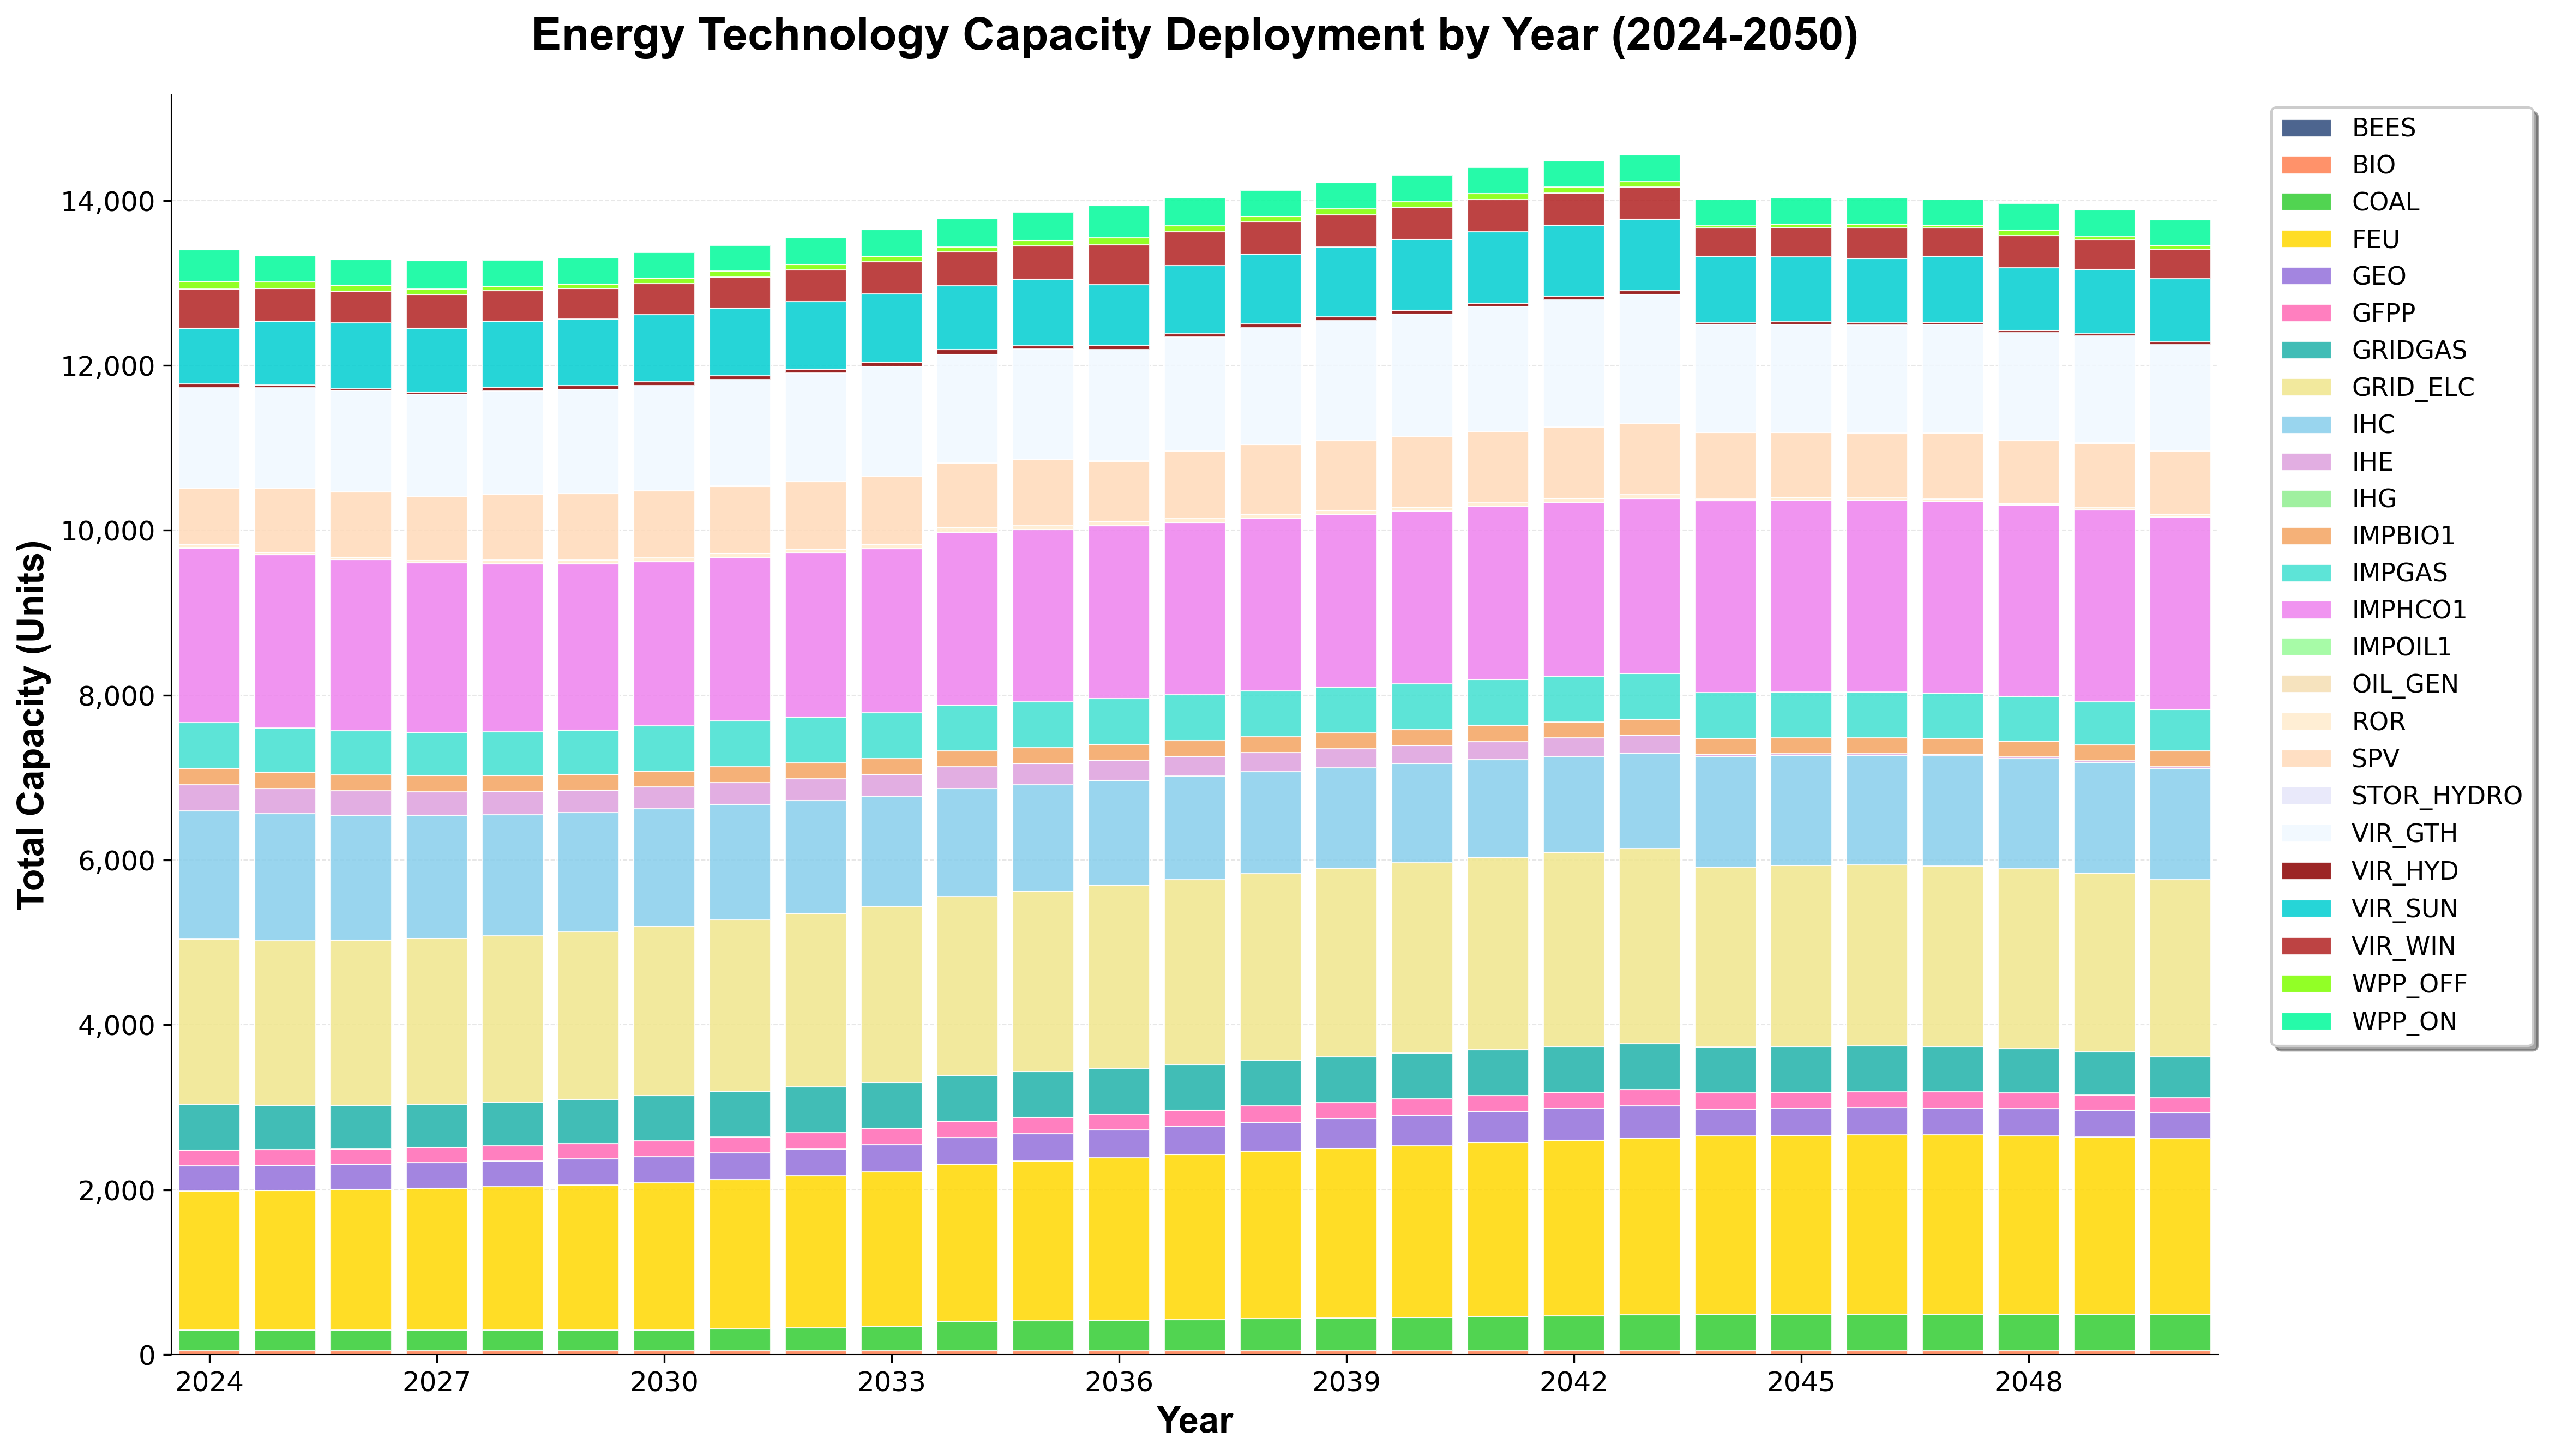

Text(2032, 7000, 'Key Milestone')

In [27]:
tot_act_annual['Year'] = tot_act_annual['Year'].astype(int)

filtered_data = tot_act_annual[(tot_act_annual['Year'] >= 2024) & (tot_act_annual['Year'] <= 2050)]

pivot_data = filtered_data.pivot_table(index='Year', columns='Technology', values='Value', aggfunc='sum', fill_value=0)

fig, ax = plt.subplots(figsize=(16, 9), dpi=300) 

colors = ['#2E4A7C', '#FF7F50', '#32CD32', '#FFD700', '#9370DB', '#FF69B4', 
          '#20B2AA', '#F0E68C', '#87CEEB', '#DDA0DD', '#90EE90', '#F4A460',
          '#40E0D0', '#EE82EE', '#98FB98', '#F5DEB3', '#FFEBCD', '#FFDAB9',
          '#E6E6FA', '#F0F8FF', '#8B0000', '#00CED1', '#B22222', '#7FFF00', '#00FA9A']

# Ensure we have enough colors
while len(colors) < len(pivot_data.columns):
    colors.extend(colors)

bottom = np.zeros(len(pivot_data))
technologies = pivot_data.columns

# Create stacked bars with slightly transparent fill
bars = []
for i, tech in enumerate(technologies):
    bar = ax.bar(pivot_data.index, pivot_data[tech], bottom=bottom, 
                 label=tech, color=colors[i], alpha=0.85, edgecolor='white', 
                 linewidth=0.5)
    bars.append(bar)
    bottom += pivot_data[tech]

ax.set_xlabel('Year', fontsize=16, fontweight='bold', fontfamily='Arial')
ax.set_ylabel('Total Capacity (Units)', fontsize=16, fontweight='bold', fontfamily='Arial')
ax.set_title('Energy Technology Capacity Deployment by Year (2024-2050)', 
             fontsize=20, fontweight='bold', fontfamily='Arial', pad=20)

ax.set_xticks(range(2024, 2051, 3))  # Every 3 years for cleaner look
ax.set_xticklabels(range(2024, 2051, 3), fontsize=12, rotation=0)
ax.set_xlim(2023.5, 2050.5)

ax.tick_params(axis='y', labelsize=12)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

# Add a subtle grid
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)  

ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=11, 
          frameon=True, fancybox=True, shadow=True)

# Remove top and right spines for cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

# Tight layout with some padding
plt.tight_layout(rect=[0, 0, 0.98, 1])

# Save with high quality
plt.savefig('total_annual_activity_by_tech.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')

plt.show()

# Optional: If you want to add trend lines or annotations
# You can uncomment and customize the following:

# # Add total capacity line
total_yearly = pivot_data.sum(axis=1)
ax2 = ax.twinx()
ax2.plot(pivot_data.index, total_yearly, color='red', linewidth=3, 
         marker='o', markersize=6, label='Total Capacity')
ax2.set_ylabel('Total Capacity', color='red', fontsize=14, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')

# # Add annotations for key years or milestones
ax.annotate('Key Milestone', xy=(2030, 5000), xytext=(2032, 7000),
            arrowprops=dict(arrowstyle='->', color='red', lw=2),
            fontsize=12, fontweight='bold')

### Dividing the technologies in groups

In [26]:
print(f"Number of unique technologies: {len(unique_techs)}")
print("Technologies:", unique_techs)

Number of unique technologies: 25
Technologies: ['IMPGAS' 'GRIDGAS' 'IMPHCO1' 'IMPOIL1' 'IMPBIO1' 'VIR_SUN' 'VIR_WIN'
 'VIR_GTH' 'VIR_HYD' 'COAL' 'GFPP' 'ROR' 'OIL_GEN' 'BIO' 'GEO' 'SPV'
 'WPP_ON' 'WPP_OFF' 'GRID_ELC' 'BEES' 'STOR_HYDRO' 'FEU' 'IHE' 'IHG' 'IHC']


In [ ]:
storage_techs = ['BEES', 'STOR_HYDRO']
techs_demand = ['FEU', 'IHE', 'IHG', 'IHC']
fossil_fuel_imports_techs = ['IMPGAS', 'GRIDGAS', 'IMPHCO1', 'IMPOIL1', 'IMPBIO1', 'VIR_SUN' 'VIR_WIN', 'VIR_GTH', 'VIR_HYD']
secondary_imports_techs = ['COAL', 'GFPP', 'ROR', 'OIL_GEN', 'BIO', 'GEO', 'SPV', 'WPP_ON', 'WPP_OFF', 'GRID_ELC']